In [1]:
import re
import sys
import math
import time
import json
import csv
import pickle
import random
import requests
import pprint
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
import scipy.stats as stat
from patsy import dmatrices
from langdetect import detect
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.stats import pearsonr
from matplotlib.dates import DateFormatter
from collections import defaultdict, Counter
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import chisquare, ttest_ind, ttest_rel, ttest_1samp
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)

In [3]:
# data_root = '/shared/0/datasets/mag/Cell/Retraction/'
data_root = '/home/haopeng/Data/Retraction/'
altmetric_start_date = datetime.strptime('2011-06-10', '%Y-%m-%d')
altmetric_end_date = datetime.strptime('2019-10-08', '%Y-%m-%d')
CIs = {'90': 1.645, '95': 1.96, '99': 2.576}
day = 24*3600

In [4]:
blog_df = pd.read_csv(data_root + 'blog_mentions_correction.csv', header = 0)
blog_set = set(blog_df.loc[~blog_df.maybe_news.isnull(), 'blog_name'])

def correct_blogs(data, error_blogs):
    for xid, paper in data.items():
        if 'blogs' in paper['posts']:
            blogs_li = paper['posts']['blogs']
            news_li = []
            if 'news' in paper['posts']:
                news_li = paper['posts']['news']
            blogs_li_new = []
            for item in blogs_li:
                try:
                    if item['author']['name'] in error_blogs:
                        news_li.append(item)
                    else:
                        blogs_li_new.append(item)
                except:
                    pass
            paper['posts']['news'] = news_li
            paper['posts']['blogs'] = blogs_li_new
    return data

In [5]:
outlets = pd.read_csv(data_root+'all_news_sources.csv', header=0)
top_outlets = set(outlets.loc[outlets.Include == 'y', 'Mention source'])

In [6]:
len(top_outlets)

27

### Load tweets

In [7]:
with open(data_root + 'tweets_processed.pickle', 'rb') as ofile:
    tid_date, tid_text, _, tid_follow_cn, retweet_org_ids = pickle.load(ofile)

In [8]:
len(tid_date)

159408

In [9]:
len(tid_text)

159408

In [10]:
len(tid_follow_cn)

159408

In [11]:
len(retweet_org_ids)

87670

### Load tweets for new control papers 

In [12]:
# run `5_critical_tweet_label_revision.ipynb` to get these tweets first.

with open(data_root + 'revision/tweets_processed_revision_v6.pickle', 'rb') as ofile:
    tid_date_new, tid_text_new, tid_follow_cn_new, retweet_org_ids_new = pickle.load(ofile)

In [13]:
for tid, val in tid_date_new.items():
    tid_date[tid] = val
    
for tid, val in tid_text_new.items():
    tid_text[tid] = val
    
for tid, val in tid_follow_cn_new.items():
    tid_follow_cn[tid] = val

for tid, val in retweet_org_ids_new.items():
    retweet_org_ids[tid] = val

In [14]:
del tid_date_new, tid_text_new, tid_follow_cn_new, retweet_org_ids_new

In [15]:
len(tid_date)

243490

### Change date format to string

In [16]:
tid_date['1100001600121098241']

datetime.datetime(2019, 2, 25, 11, 56, 33)

In [17]:
# change tweet date format to str to keep it the same pattern as date on other platforms.
for tid, tdate in tid_date.items():
    tdate = tdate.strftime("%Y-%m-%dT%H:%M:%S")
    tid_date[tid] = tdate

In [18]:
tid_date['1100001600121098241']

'2019-02-25T11:56:33'

### Load uncertainty tweets

In [639]:
all_tweets_df = pd.read_csv(data_root + 'revision/all_tweets_uncertain_label_revision_share.csv', quoting=csv.QUOTE_ALL, header=0, dtype={'tid': 'str'})


In [628]:
uncertain_tids = all_tweets_df.loc[all_tweets_df.majority_vote == 1, 'tid'].tolist()

In [629]:
len(uncertain_tids)

916

### (SI) Load critical tweets (treat umbiguous tweets as critical ones)

In [654]:
uncertain_tids = []

for tid, mh, lab, fourth, mv in zip(all_tweets_df['tid'], all_tweets_df['meet_heuristic'], all_tweets_df['three_labels'], all_tweets_df['fourth_label'], all_tweets_df['majority_vote']):
    if mh == 1:
        # must have three labels
        if '.' in lab:
            lab_li = [int(x) for x in lab[1:-2].split('. ')]
        else:
            lab_li = [int(x) for x in lab[1:-1].split(' ')]
        if ~np.isnan(fourth):
            # 001 0
            # 001 1
            # --
            # 011 0
            # 011 1
            if np.sum(lab_li) + fourth > 1:
                uncertain_tids.append(tid)
        else:
            if np.sum(lab_li) == 3:
                uncertain_tids.append(tid)

In [655]:
len(uncertain_tids)

1275

### Prepare data for control papers

In [23]:
altid_data = {}

with open(data_root+"revision/control_alt_papers_revision_v6.json", 'r') as ffile:
    for row in ffile:
        paper = json.loads(row)
        altid = str(paper['altmetric_id'])
        altid_data[altid] = paper
        
altid_data = correct_blogs(altid_data, blog_set)

In [24]:
len(altid_data)

19255

In [25]:
doi_control_aids ={}

with open(data_root+"revision/doi_control_alt_ids_revision_v6.json", 'r') as ffile:
    for line in ffile:
        line = json.loads(line)
        doi_control_aids[line['doi']] = [str(x) for x in line['alt_ids']]

In [26]:
len(doi_control_aids)

3851

In [27]:
control_aid_doi = {}
for doi, ids in doi_control_aids.items():
    for alt_id in ids:
        control_aid_doi[alt_id] = doi

In [28]:
def get_doi(altid):
    paper = altid_data[altid]
    if 'doi' in paper['citation']:
        return paper['citation']['doi'].lower()
    else:
        return ''

def get_title(altid):
    paper = altid_data[altid]
    if 'title' in paper['citation']:
        return paper['citation']['title']
    else:
        return ''

def get_abs(altid):
    paper = altid_data[altid]
    if 'abstract' in paper['citation']:
        return paper['citation']['abstract']
    else:
        return ''

def get_pub_date_alt(altid):
    paper = altid_data[altid]
    dt_li = []
    if 'pubdate' in paper['citation']:
        dt_li.append(datetime.strptime(paper['citation']['pubdate'][:10], '%Y-%m-%d'))
    if 'epubdate' in paper['citation']:
        dt_li.append(datetime.strptime(paper['citation']['epubdate'][:10], '%Y-%m-%d'))
    if 'first_seen_on' in paper['citation']:
        dt_li.append(datetime.strptime(paper['citation']['first_seen_on'][:10], '%Y-%m-%d'))
    return min(dt_li)

def get_journal(altid):
    paper = altid_data[altid]
    return paper['citation']['journal']

def get_author(altid):
    paper = altid_data[altid]
    if 'authors' in paper['citation']:
        return ';'.join(paper['citation']['authors'])
    else:
        return ''
    
def get_subs(altid):
    paper = altid_data[altid]
    if 'scopus_subjects' in paper['citation']:
        return ';'.join(paper['citation']['scopus_subjects'])
    else:
        return ''
    
def check_usable_days(pub_date):
    if pub_date < altmetric_end_date:
        return int((altmetric_end_date - pub_date).total_seconds()/day)
    else:
        return -1

In [29]:
control_df = pd.DataFrame(altid_data.keys(), columns=['altmetric_id'])

In [30]:
control_df['matched_retract_doi'] = control_df.altmetric_id.map(control_aid_doi)

In [31]:
control_df['doi'] = control_df.altmetric_id.apply(get_doi)
control_df['title'] = control_df.altmetric_id.apply(get_title)
control_df['abstract'] = control_df.altmetric_id.apply(get_abs)
control_df['altmetric_pub_date'] = control_df.altmetric_id.apply(get_pub_date_alt)
control_df['journal'] = control_df.altmetric_id.apply(get_journal)
control_df['authors'] = control_df.altmetric_id.apply(get_author)
control_df['scopus_subjects'] = control_df.altmetric_id.apply(get_subs)
control_df['altmetric_score'] = control_df.altmetric_id.apply(lambda aid: altid_data[aid]['altmetric_score']['score'])

In [32]:
control_df['usable_days'] = control_df.altmetric_pub_date.apply(check_usable_days)

In [33]:
len(control_df)

19255

Build time series feats

In [34]:
plat_cate = {
 'blogs': 'blog',
 'news': 'news_media',
 'patent': 'knowledge_repo',
 'f1000': 'knowledge_repo',
 'peer_reviews': 'knowledge_repo',
 'wikipedia': 'knowledge_repo',
 'q&a': 'knowledge_repo',
 'facebook': 'social_media',
 'googleplus': 'social_media',
 'linkedin': 'social_media',
 'pinterest': 'social_media',
 'reddit': 'social_media',
 'twitter': 'social_media',
 'video': 'social_media'
}

In [35]:
def get_time_series_list(altid, category, altid_data):
    paper = altid_data[altid]
    time_li = []
    if 'posts' in paper:
        for plat in paper['posts']:
            # ignore misc.
            if plat in plat_cate and plat_cate[plat] == category:
                for item in paper['posts'][plat]:
                    if plat == 'twitter':
                        tid = item['tweet_id']
                        if tid in tid_date:
                            time_li.append(tid_date[tid])
                    else:
                        if 'posted_on' in item:
                            tdate = item['posted_on'][:19]
                            text = ''
                            if 'title' in item and item['title']:
                                text += item['title']
                            if 'summary' in item and item['summary']:
                                text = text + ' ' + item['summary']
                            try:
                                if detect(text) == 'en':
                                    time_li.append(tdate)
                            except:
                                pass
    return sorted(time_li)

def get_top_news_time_series_list(altid, altid_data):
    paper = altid_data[altid]
    time_li = []
    if 'posts' in paper and 'news' in paper['posts']:
        for item in paper['posts']['news']:
            if 'posted_on' in item:
                tdate = item['posted_on'][:19]
                name = item['author']['name']
                # these top outlets are English language outlets, so we don't need to filter here.
                if name in top_outlets:
                    time_li.append(tdate)
    return sorted(time_li)

def get_uncertain_time_series_list(altid, altid_data):
    paper = altid_data[altid]
    time_li = []
    if 'posts' in paper and 'twitter' in paper['posts']:
        for item in paper['posts']['twitter']:
            tid = item['tweet_id']
            if tid in uncertain_tids: # non retweet
                if tid in tid_date:
                    time_li.append(tid_date[tid])
            else: # might be retweet or original tweet but is normal tweet
                if tid in retweet_org_ids:
                    org_id = retweet_org_ids[tid]
                    if org_id in uncertain_tids and tid in tid_date:
                        time_li.append(tid_date[tid])
    return sorted(time_li)

def get_tweet_ids(altid, altid_data):
    paper = altid_data[altid]
    tids_li = []
    if 'posts' in paper and 'twitter' in paper['posts']:
        for item in paper['posts']['twitter']:
            tid = item['tweet_id']
            if tid in tid_date:
                tids_li.append(tid)
    return tids_li

def get_tw_follow_sort_date(tids):
    lii = []
    for tid in tids:
        lii.append((tid_date[tid], tid_follow_cn[tid]))
    return sorted(lii, key=lambda x: x[0])

def get_tw_date_sort(lli):
    return [dtt for (dtt, fcn) in lli]

def get_tw_fcn_date_sort(lli):
    return [fcn for (dtt, fcn) in lli]

In [36]:
control_df['news_media'] = control_df.altmetric_id.apply(get_time_series_list, args=['news_media', altid_data])
control_df['social_media'] = control_df.altmetric_id.apply(get_time_series_list, args=['social_media', altid_data])
control_df['blog'] = control_df.altmetric_id.apply(get_time_series_list, args=['blog', altid_data])
control_df['knowledge_repo'] = control_df.altmetric_id.apply(get_time_series_list, args=['knowledge_repo', altid_data])
control_df['top_news'] = control_df.altmetric_id.apply(get_top_news_time_series_list, args=[altid_data])

In [37]:
control_df['tweet_ids'] = control_df.altmetric_id.apply(get_tweet_ids, args=[altid_data])
control_df['date_tweet_fcn'] = control_df.tweet_ids.apply(get_tw_follow_sort_date)
control_df['tw_date_sort'] = control_df.date_tweet_fcn.apply(get_tw_date_sort)
control_df['fcn_date_sort'] = control_df.date_tweet_fcn.apply(get_tw_fcn_date_sort)
control_df = control_df.drop(columns=['date_tweet_fcn'])

In [529]:
control_df['uncertainty'] = control_df.altmetric_id.apply(get_uncertain_time_series_list, args=[altid_data])

In [493]:
# SI: treat umbiguous ones as positives
# control_df['uncertainty'] = control_df.altmetric_id.apply(get_uncertain_time_series_list, args=[altid_data])

In [39]:
len(control_df)

19255

In [40]:
control_df.head(1)

,altmetric_id,matched_retract_doi,doi,title,abstract,altmetric_pub_date,journal,authors,scopus_subjects,altmetric_score,usable_days,news_media,social_media,blog,knowledge_repo,top_news,tweet_ids,tw_date_sort,fcn_date_sort,uncertainty
0,21408520,10.1111/1440-1681.12374,10.1111/1440-1681.12806,Salinomycin overcomes acquired tamoxifen resis...,Salinomycin is a monocarboxylic polyether iono...,2017-06-29,Clinical & Experimental Pharmacology & Physiology,Suwisit Manmuan;Nithidol Sakunrangsit;Wannaras...,"Biochemistry, Genetics and Molecular Biology;H...",0.25,831,[],[2017-06-29T10:07:10],[],[],[],[880367027793178625],[2017-06-29T10:07:10],[826],[]


### Compare with retracted papers

In [41]:
doi_alt_data = {}

with open(data_root+"retraction_altmetric.json", 'r') as ffile:
    for row in ffile:
        record = json.loads(row)
        doi = record['citation']['doi'].lower()
        doi_alt_data[doi] = record
        
doi_alt_data = correct_blogs(doi_alt_data, blog_set)

In [511]:
with open(data_root+'df_retract_clean.pickle', 'rb') as file:
    retract_df = pickle.load(file)

In [512]:
len(retract_df)

6680

In [510]:
# if want to treat ambiguous critical tweets as positives, run the following code:
# retract_df['uncertainty'] = retract_df.OriginalPaperDOI.apply(get_uncertain_time_series_list, args=[doi_alt_data])

### Focus on papers published after Alt db start date

In [513]:
retract_df = retract_df.loc[retract_df.pub_date_corrected.apply(lambda dttt: (dttt-altmetric_start_date).total_seconds() > 0)]
retract_df.index = range(len(retract_df))

In [514]:
retract_df = retract_df.loc[retract_df.OriginalPaperDOI.isin(doi_control_aids)]
retract_df.index = range(len(retract_df))

In [515]:
len(retract_df)

3659

In [516]:
doi_ret_date = dict(zip(retract_df['OriginalPaperDOI'], retract_df['RetractionDate']))

In [517]:
# num of matched controls papers for retracted papers after Alt start date.
control_df = control_df.loc[control_df['matched_retract_doi'].isin(doi_ret_date)]
control_df.index = range(len(control_df))

In [50]:
# num of matched controls papers after Alt start date.
control_df = control_df.loc[control_df.altmetric_pub_date.apply(lambda dttt: (dttt-altmetric_start_date).total_seconds() > 0)]
control_df.index = range(len(control_df))

In [51]:
len(control_df)

17782

In [52]:
with open(data_root+'revision/df_control_revision_v6.pickle', 'wb') as file:
    pickle.dump(control_df, file)

In [53]:
# with open(data_root+'revision/df_control_revision_v6.pickle', 'rb') as file:
#     control_df = pickle.load(file)

### (SI) Exclude general journals

In [807]:
# https://en.wikipedia.org/wiki/List_of_scientific_journals#General_and_multidisciplinary_science

general_J = {
'Nature',
'Nature Communications',
'Philosophical Transactions of the Royal Society A',
'PLoS One',
'PNAS: Proceedings of the National Academy of Sciences of the United States of America',
'Proceedings of the Royal Society A: Mathematics, Physical and Engineering Sciences',
'Science',
'Science Advances',
'Scientific Reports'}

In [808]:
retract_df = retract_df.loc[~retract_df.Journal.isin(general_J)]
retract_df.index = range(len(retract_df))

In [809]:
len(retract_df)

3378

In [810]:
control_df = control_df.loc[~control_df.journal.isin(general_J)]
control_df.index = range(len(control_df))

In [811]:
len(control_df)

17350

### (SI) Audience analysis

In [393]:
len(retract_df)

3659

In [587]:
doi_alt_data['10.1038/nature13375']['demographics']['users']['twitter']['cohorts']

{'Members of the public': 8,
 'Practitioners (doctors, other healthcare professionals)': 2,
 'Scientists': 2}

In [591]:
utype_cn = defaultdict(int)

for doi in retract_df.OriginalPaperDOI:
    if 'poster_types' in doi_alt_data[doi]['demographics']:
        for utype, cn in doi_alt_data[doi]['demographics']['poster_types'].items():
            utype_cn[utype] += cn

In [592]:
utype_cn

defaultdict(int,
            {'member_of_the_public': 44289,
             'researcher': 8474,
             'practitioner': 3798,
             'science_communicator': 1624})

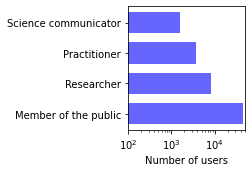

In [601]:
fig, ax = plt.subplots(figsize = (3.6, 2.5))

utypes, cns = [], []
for utype, cn in utype_cn.items():
    utypes.append(utype)
    cns.append(cn)

ax.barh(y=utypes, width = cns, height=0.7,  alpha = 0.6, capsize = 3, color='blue')
# legend = ax.legend(loc=[0.45, 0.7], numpoints=1, labelspacing = 0.15, shadow=False, frameon = True)
# ax.set_yticks()
# ax.set_yticklabels([name_pos[pos] for pos in aut_pos], rotation=0, ha='right')
ax.set_xlabel('Number of users')
ax.set_xscale('log')
ax.set_xlim([0, 5e4])
ax.set_xticks([100, 1000, 10000])
ax.set_yticklabels(['Member of the public', 'Researcher', 'Practitioner', 'Science communicator'])
plt.tight_layout()
plt.show()
fig.savefig('./audience_freq.pdf', bbox_inches='tight', pad_inches=0.02)

### (SI) Distribution of tweet mentions of retracted papers

In [545]:
num_tweets = []

for doi in retract_df.OriginalPaperDOI:
    try:
        num_tweets.append(len(doi_alt_data[doi]['posts']['twitter']))
    except:
        pass

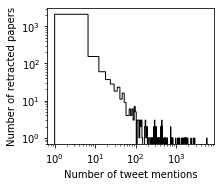

In [551]:
fig, ax = plt.subplots(figsize=(3, 2.5))
ax.hist(num_tweets, bins = 1000, facecolor='blue', alpha=1, color = 'black', histtype='step')
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim(0, 2000)
ax.set_xlabel('Number of tweet mentions')
ax.set_ylabel('Number of retracted papers')
plt.show()
fig.savefig('ret_tweets_dist.pdf', bbox_inches='tight', pad_inches=0.01)

### Histogram of the time difference between pub and retraction date

In [54]:
gap_days = retract_df.apply(lambda row: int((row['RetractionDate'] - row['pub_date_corrected']).total_seconds()/day), axis = 1).tolist()

In [55]:
len(gap_days)

3659

In [56]:
np.median(gap_days)

480.0

In [57]:
np.mean(gap_days)

697.9721235310194

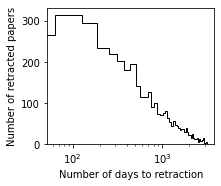

In [58]:
fig, ax = plt.subplots(figsize=(3, 2.5))
ax.hist(gap_days, bins = 50, facecolor='blue', alpha=1, color = 'black', histtype='step')
# ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim(0, 2000)
ax.set_xlabel('Number of days to retraction')
ax.set_ylabel('Number of retracted papers')
plt.show()
fig.savefig('pub_ret_gap_days.pdf', bbox_inches='tight', pad_inches=0.01)

### Build control df for after retraction analysis (removing posts with keyword "retract")

In [59]:
altid_data_filter = {}

for aid in control_df.altmetric_id.to_list():
    paper = altid_data[aid]
    altid_data_filter[aid] = paper.copy()
    if 'posts' in paper:
        temp = defaultdict(list)
        for plat in paper['posts']:
            if plat in plat_cate:
                for item in paper['posts'][plat]:
                    if plat == 'twitter':
                        tid = item['tweet_id']
                        if tid in tid_date:
                            tdate = tid_date[tid]
                            tdate = datetime.strptime(tdate, '%Y-%m-%dT%H:%M:%S')
                            text = tid_text[tid]
                            if 'retract' not in text.lower():
                                temp[plat].append(item)
                    else:
                        if 'posted_on' in item:
                            tdate = item['posted_on'][:19]
                            tdate = datetime.strptime(tdate, '%Y-%m-%dT%H:%M:%S')
                            text = ''
                            if 'title' in item and item['title']:
                                text += item['title']
                            if 'summary' in item and item['summary']:
                                text = text + ' ' + item['summary']
                            if 'retract' not in text.lower():
                                temp[plat].append(item)
        altid_data_filter[aid]['posts'] = temp

In [60]:
control_df_filter = control_df.copy()

In [61]:
control_df_filter['news_media'] = control_df_filter.altmetric_id.apply(get_time_series_list, args=['news_media', altid_data_filter])
control_df_filter['social_media'] = control_df_filter.altmetric_id.apply(get_time_series_list, args=['social_media', altid_data_filter])
control_df_filter['blog'] = control_df_filter.altmetric_id.apply(get_time_series_list, args=['blog', altid_data_filter])
control_df_filter['knowledge_repo'] = control_df_filter.altmetric_id.apply(get_time_series_list, args=['knowledge_repo', altid_data_filter])
control_df_filter['top_news'] = control_df_filter.altmetric_id.apply(get_top_news_time_series_list, args=[altid_data_filter])


In [62]:
control_df_filter['tweet_ids'] = control_df_filter.altmetric_id.apply(get_tweet_ids, args=[altid_data_filter])
control_df_filter['date_tweet_fcn'] = control_df_filter.tweet_ids.apply(get_tw_follow_sort_date)
control_df_filter['tw_date_sort'] = control_df_filter.date_tweet_fcn.apply(get_tw_date_sort)
control_df_filter['fcn_date_sort'] = control_df_filter.date_tweet_fcn.apply(get_tw_fcn_date_sort)
control_df_filter = control_df_filter.drop(columns=['date_tweet_fcn'])

In [63]:
control_df_filter['uncertainty'] = control_df_filter.altmetric_id.apply(get_uncertain_time_series_list, args=[altid_data_filter])

In [64]:
len(control_df_filter)

17782

### Build retraction df for post retraction analysis (removing retraction-discussion posts)

In [65]:
# this file is processed in `6_retract_vs_control.ipynb` in the initial submission (before revision).

with open(data_root+'df_retract_clean_filter.pickle', 'rb') as file:
    retract_df_filter = pickle.load(file)

In [66]:
retract_df_filter = retract_df_filter.loc[retract_df_filter['Record ID'].isin(retract_df['Record ID'])]
retract_df_filter.index = range(len(retract_df_filter))

In [67]:
def get_time_seg(start, end, sliding):
    num = int(math.ceil((end - start).total_seconds()/(sliding*day)))
    if num <= 1:
        return [[start, end]]
    else:
        time_segments = []
        for i in range(0, num):
            begin = start + i * dt.timedelta(days = sliding)
            stop = begin + dt.timedelta(days = sliding)
            if stop <= end:
                time_segments.append([begin, stop])
        if time_segments[-1][1] < end:
            time_segments.append([time_segments[-1][1], end])
    return time_segments

def time_freq_helper(date_li, sdate, sliding, length, time_type):
    if time_type == 'early' or time_type == 'after_retract':
        time_segments = get_time_seg(sdate, sdate + dt.timedelta(days = length), sliding)
    if time_type == 'late':
        time_segments = get_time_seg(sdate - dt.timedelta(days = length), sdate, sliding)
    freqs = [0] * len(time_segments)
    date_index = 0
    begin, stop = time_segments[date_index]
    for dtt in date_li:
        if date_index < len(time_segments):
            arrived = False
            while not arrived:
                if (dtt - begin).total_seconds() >= 0:
                    if (stop - dtt).total_seconds() > 0:
                        arrived = True
                    else:
                        date_index += 1
                        if date_index == len(time_segments):
                            break
                        begin, stop = time_segments[date_index]
                else:
                    break
            if arrived and date_index < len(time_segments):
                freqs[date_index] += 1
    return freqs

def all_cate(row, sdate, sliding, length, time_type):
    matrix = []
    for date_li in row[cates].values.flatten():
        date_li = [datetime.strptime(dtt, '%Y-%m-%dT%H:%M:%S') for dtt in date_li]
        freqs = time_freq_helper(date_li, sdate, sliding, length, time_type)
        matrix.append(freqs)
    return matrix
            

def get_time_freq(row, key_col, sliding, length, length_type, time_type):
    # first x months after pub_date
    if time_type == 'early':
        if key_col == 'doi':
            # retract usable_days is from pub_date to min(retract_date, alt_end_date).
            pub_date, usable_days = row[['pub_date_corrected', 'usable_days']]
        else:
            # control usable_days is from pub_date to alt_end_date.
            pub_date, usable_days = row[['altmetric_pub_date', 'usable_days']]
        if usable_days >= length:
            return all_cate(row, pub_date, sliding, length, time_type)
        else:
            return []
                
    # last x months before retract_date
    if time_type == 'late':
        if key_col == 'doi':
            retract_date, usable_days = row[['RetractionDate', 'usable_days']]
            # retract_date has to be before alt_end_date
            if retract_date <= altmetric_end_date:
                if length_type == 'minimum':
                    if usable_days >= length:
                        return all_cate(row, retract_date, sliding, length, time_type)
                    else:
                        return []
                if length_type == 'exact_months':
                    if length < 55 * 30:
                        if usable_days >= length and usable_days < (length + sliding*6):
                            return all_cate(row, retract_date, sliding, length, time_type)
                        else:
                            return []
                    else:
                        if usable_days >= length:
                            return all_cate(row, retract_date, sliding, length, time_type)
                        else:
                            return []
            else:
                return []
        else:
            alt_id, pub_date, retract_doi = row[['altmetric_id', 'altmetric_pub_date', 'matched_retract_doi']]
            fake_retract_date = doi_ret_date[retract_doi]
            if fake_retract_date <= altmetric_end_date:
                usable_days = int((fake_retract_date - pub_date).total_seconds()/day)
                if usable_days >= length:
                    return all_cate(row, fake_retract_date, sliding, length, time_type)
                else:
                    return []
            else:
                return []
                    
    if time_type == 'after_retract':
        if key_col == 'doi':
            retract_date = row['RetractionDate']
            if int((altmetric_end_date - retract_date).total_seconds()/day) >= length:
                return all_cate(row, retract_date, sliding, length, time_type)
            else:
                return []
        else:
            alt_id, retract_doi = row[['altmetric_id', 'matched_retract_doi']]
            fake_retract_date = doi_ret_date[retract_doi]
            if int((altmetric_end_date - fake_retract_date).total_seconds()/day) >= length:
                return all_cate(row, fake_retract_date, sliding, length, time_type)
            else:
                return []

def process_df(df, key_col, sliding = 30, length = 180, length_type = 'minimum', time_type = 'early'):
    series_data = []
    keys = []
    for ix, row in df.iterrows():
        if key_col == 'doi':
            key = row['OriginalPaperDOI']
        if key_col == 'altid':
            key = row['altmetric_id']
        mat = get_time_freq(row, key_col, sliding, length, length_type, time_type)
        if mat != []:
            series_data.append(mat)
            keys.append(key)
    return keys, np.array(series_data)

In [68]:
def U_test(cate, series_data_control, series_data_retract):
    x_control = np.sum(series_data_control, axis = 1)
    x_retract = np.sum(series_data_retract, axis = 1)
    _, p_t = ttest_ind(x_control, x_retract)
    _, p_u = stat.mannwhitneyu(x_control, x_retract, alternative='two-sided')
    print('avg. total mentions (Retract vs. Control): %.3f vs. %.3f (p = %.3f); U-test: p = %.3f (%s)'%(np.mean(x_retract), np.mean(x_control), p_t, p_u, cate))

def plot(ax, cate, series_data_control, series_data_retract, how = 'per_window', time_type = 'early'):
    # series_data_control = np.log(series_data_control + 1)
    # series_data_retract = np.log(series_data_retract + 1)
    if how == 'cumulative':
        if time_type == 'late':
            series_data_control = np.cumsum(series_data_control[..., ::-1], axis = 1)[..., ::-1]
            series_data_retract = np.cumsum(series_data_retract[..., ::-1], axis = 1)[..., ::-1]
        else:
            series_data_control = np.cumsum(series_data_control, axis = 1)
            series_data_retract = np.cumsum(series_data_retract, axis = 1)
    if how == 'per_window':
        if time_type == 'late':
            series_data_control = series_data_control[..., ::-1]
            series_data_retract = series_data_retract[..., ::-1]
    ys_1 = np.mean(series_data_control, axis=0)
    std_1 = np.std(series_data_control, axis=0)
    ys_2 = np.mean(series_data_retract, axis=0)
    std_2 = np.std(series_data_retract, axis=0)
    xs = np.arange(len(ys_1)) + 1
    col1 = 'k' #'#0057e7'
    col2 = '#ffa500' #'#d62d20'
    ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(series_data_control))), color=col1, fmt='-o', markersize=4, capsize=3, label='control')
    ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(series_data_retract))), color=col2, fmt='-o', markersize=4, capsize=3, label='retracted')
    # ax.set_xlabel(xlab)
    if cate != '':
        ax.set_title(cate)
    # ax.tick_params(axis='y', labelcolor = col1, direction='in')
    # ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    # ax.set_ylim([0, 6e-4])

def boot_perc(series_data_control, p = 95, rep = 1000):
    percs = []
    confs = []
    n = series_data_control.shape[0]
    for i in range(series_data_control.shape[1]):
        disc = []
        for j in range(rep):
            re_sam = np.random.choice(series_data_control[:, i], size=n, replace=True)
            disc.append(np.percentile(re_sam, q=p))
        mu = np.mean(disc)
        percs.append(mu)
        lci, uci = np.percentile(disc, q=[2.5, 97.5])
        confs.append([mu-lci, uci-mu])
    return (np.array(percs), np.array(confs).T)

def plot_percentile(ax, cate, series_data_control, series_data_retract, p = 0.95, how = 'per_window', time_type = 'early'):
    # series_data_control = np.log(series_data_control + 1)
    # series_data_retract = np.log(series_data_retract + 1)
    if how == 'cumulative':
        if time_type == 'late':
            series_data_control = np.cumsum(series_data_control[..., ::-1], axis = 1)[..., ::-1]
            series_data_retract = np.cumsum(series_data_retract[..., ::-1], axis = 1)[..., ::-1]
        else:
            series_data_control = np.cumsum(series_data_control, axis = 1)
            series_data_retract = np.cumsum(series_data_retract, axis = 1)
    ys_1, confs_1 = boot_perc(series_data_control, p)
    ys_2, confs_2 = boot_perc(series_data_retract, p)
    if time_type == 'late':
        xs = np.arange(len(ys_1)*-1, 0)
    else:
        xs = np.arange(len(ys_1)) + 1
    # fig, ax = plt.subplots(figsize = (3, 2.5))
    col1 = 'k' #'#0057e7'
    col2 = '#ffa500' #'#d62d20'
    ax.errorbar(xs, ys_1, yerr=confs_1, color=col1, fmt='-o', markersize=4, capsize=3, label='control')
    ax.errorbar(xs, ys_2, yerr=confs_2, color=col2, fmt='-o', markersize=4, capsize=3, label='retracted')
    # ax.set_xlabel(xlab)
    if cate != '':
        ax.set_title(cate)

def plot_after(ax, cate, series_data_control, series_data_retract, series_data_retract_filter, plot_filter=True, how="cumulative"):
    if how=="cumulative":
        series_data_control = np.cumsum(series_data_control, axis = 1)
        series_data_retract = np.cumsum(series_data_retract, axis = 1)
        series_data_retract_filter = np.cumsum(series_data_retract_filter, axis = 1)
    ys_1 = np.mean(series_data_control, axis=0)
    std_1 = np.std(series_data_control, axis=0)
    ys_2 = np.mean(series_data_retract, axis=0)
    std_2 = np.std(series_data_retract, axis=0)
    ys_3 = np.mean(series_data_retract_filter, axis=0)
    std_3 = np.std(series_data_retract_filter, axis=0)
    xs = np.arange(len(ys_1)) + 1
    col1 = 'k' #'#0057e7'
    col2 = '#ffa500' #'#d62d20'
    ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(series_data_control))), color=col1, fmt='--o', markersize=4, capsize=3, label='control (filtered)')
    ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(series_data_retract))), color=col2, fmt='-o', markersize=4, capsize=3, label='retracted')
    if plot_filter:
        ax.errorbar(xs, ys_3, yerr=CIs['95']*(std_3/np.sqrt(len(series_data_retract_filter))), color=col2, fmt='--o', markersize=4, capsize=3, label='retracted (filtered)')
    # ax.set_xlabel(xlab)
    ax.set_title(cate)

def plot_hist(cate, series_data_control, series_data_retract, xlab = 'Week number', time_type = 'early'):
    series_data_control = np.cumsum(series_data_control, axis = 1)
    series_data_retract = np.cumsum(series_data_retract, axis = 1)
    data_li_1 = list(series_data_control.T)
    data_li_2 = list(series_data_retract.T)
    print(np.mean(data_li_2[5]), np.mean(data_li_1[5]))
    print(np.median(data_li_2[5]), np.median(data_li_1[5]))
    print(np.percentile(data_li_2[5], [25, 75]), np.percentile(data_li_1[5], [25, 75]))
    if time_type != 'late':
        xs = np.arange(len(data_li_1)) + 1
    else:
        xs = np.arange(len(data_li_1)*-1, 0)
    fig, ax = plt.subplots(figsize = (3, 2.5))
    col1 = '#0057e7'
    col2 = '#d62d20'
    print(len(data_li_2[5]), len(data_li_1[5]))
    ax.hist(data_li_1[5], bins = 50, facecolor=col1, alpha=0.6, label='control')
    ax.hist(data_li_2[5], bins = 50, facecolor=col2, alpha=0.6, label='retract')
    ax.set_ylabel('Num. of papers')
    ax.set_xlabel(xlab)
    ax.set_title(cate)
    ax.set_yscale('log')
    # ax.set_xlim([0, 1000])
    legend = ax.legend(loc=[0.55, 0.7], numpoints=2, labelspacing = 0.15, shadow=False, frameon = False)
    plt.show()
    fig.savefig('%s_%s.pdf'%(time_type, cate), bbox_inches='tight', pad_inches=0.01)

In [69]:
def cal_exc_uncertain(series_control_early, how = 'cumulative'):
    uncertain = np.array([ts[0] for ts in series_control_early])
    total = np.array([ts[1] for ts in series_control_early])
    result = total - uncertain
    if how == 'cumulative':
        result = np.cumsum(result, axis = 1)
    return result

def cal_frac(series_control_early, how = 'cumulative'):
    nume = np.array([ts[0] for ts in series_control_early])
    deno = np.array([ts[1] for ts in series_control_early])
    if how == 'cumulative':
        nume = np.cumsum(nume, axis = 1)
        deno = np.cumsum(deno, axis = 1)
    fracs = []
    for i in range(nume.shape[1]):
        frac = []
        for a, b in zip(nume[:, i], deno[:, i]):
            if b > 0:
                frac.append(a/b)
        fracs.append(frac)
    return fracs

## Trajectory

### After publication

In [78]:
slide = 30
length = 180

In [78]:
# slide = 30
# length = 90

In [79]:
cates = ['social_media', 'blog', 'knowledge_repo', 'news_media', 'top_news']
cates_names = ['Social Media', 'Blogs', 'Knowledge Repositories', 'News Media', 'Top News']

In [618]:
keys_2, series_retract_early = process_df(retract_df, key_col='doi', sliding=slide, length=length)
# exclude control papers for excluded retracted ones.
control_tem = control_df.loc[control_df['matched_retract_doi'].isin(keys_2)]
control_tem.index = range(len(control_tem))
keys_1, series_control_early = process_df(control_tem, key_col='altid', sliding=slide, length=length)

ixx = []
for i, doi in enumerate(keys_2):
    keep = False
    for altid in doi_control_aids[doi]:
        if altid in keys_1:
            keep = True
            break
    if keep:
        ixx.append(i)
        
keys_2 = [keys_2[i] for i in ixx]
series_retract_early = series_retract_early[ixx]

In [73]:
len(series_retract_early)

2830

In [74]:
len(series_control_early)

13599

In [75]:
# ratio of mean
# only resample retracted papers each time.
plat_ratios_boot = defaultdict(list)
for i, cate in enumerate(cates_names):
    series_data_control = {aid: sum(ts[i]) for aid, ts in zip(keys_1, series_control_early)}
    series_data_retract = {doi: sum(ts[i]) for doi, ts in zip(keys_2, series_retract_early)}
    for j in range(5000):
        sam_dois = np.random.choice(keys_2, size=len(keys_2), replace=True)
        sam_aids = []
        for doi in sam_dois:
            sam_aids.extend([aid for aid in doi_control_aids[doi] if aid in series_data_control])
        sam_retract = [series_data_retract[doi] for doi in sam_dois]
        sam_control = [series_data_control[aid] for aid in sam_aids]
        plat_ratios_boot[cate].append(np.mean(sam_retract)/np.mean(sam_control))

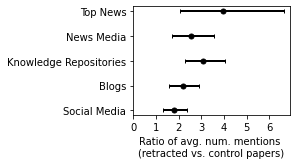

In [76]:
fig, ax = plt.subplots(figsize = (2.8, 2), nrows=1, ncols=1)

xs, ys, confs = [], [], []
for cate, ratios in plat_ratios_boot.items():
    ys.append(cate)
    mu = np.mean(ratios)
    xs.append(mu)
    lci, uci = np.percentile(ratios, q=[2.5, 97.5])
    confs.append([mu - lci, uci - mu])
#     std = np.std(ratios)
#     confs.append(CIs['95']*(std/np.sqrt(len(ratios))))
    
ax.errorbar(xs, ys, xerr=np.array(confs).T, color='k', fmt='o', markersize=5, capsize=2, linewidth=2)
# ax.errorbar(xs, ys, xerr=confs, color='k', fmt='o', markersize=5, capsize=2, linewidth=2)

ax.set_xlabel('Ratio of avg. num. mentions \n(retracted vs. control papers)')
# fig.text(0.29, -0.06, 'Ratio of avg. num. mentions (retracted vs. control)', ha='center', va='center')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
plt.show()
fig.savefig('plat_ratio.pdf', bbox_inches='tight', pad_inches=0.01)

avg. total mentions (Retract vs. Control): 7.180 vs. 4.011 (p = 0.000); U-test: p = 0.000 (Social Media)
avg. total mentions (Retract vs. Control): 0.160 vs. 0.073 (p = 0.000); U-test: p = 0.004 (Blogs)
avg. total mentions (Retract vs. Control): 0.088 vs. 0.029 (p = 0.000); U-test: p = 0.000 (Knowledge Repositories)
avg. total mentions (Retract vs. Control): 0.845 vs. 0.335 (p = 0.000); U-test: p = 0.673 (News Media)
avg. total mentions (Retract vs. Control): 0.046 vs. 0.012 (p = 0.000); U-test: p = 0.000 (Top News)


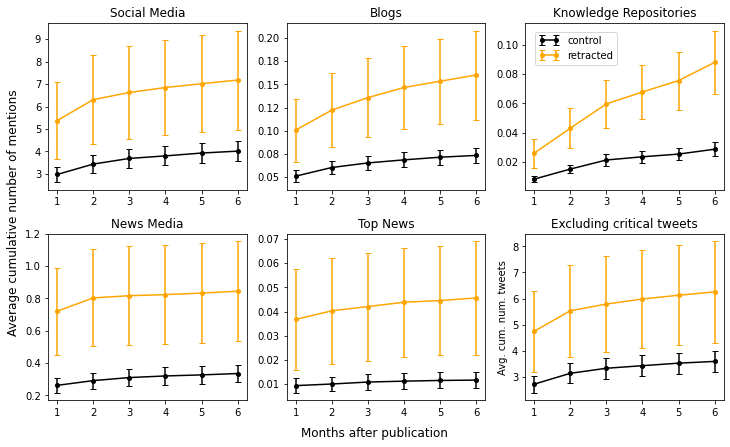

In [620]:
fig, axes = plt.subplots(figsize = (10, 6), nrows=2, ncols=3)

for i, cate in enumerate(cates_names):
    ax = axes[i//3, i%3]
    series_data_control = np.array([ts[i] for ts in series_control_early])
    series_data_retract = np.array([ts[i] for ts in series_retract_early])
    U_test(cate, series_data_control, series_data_retract)
    plot(ax, cate, series_data_control, series_data_retract, how='cumulative', time_type='early')
    if i == 2 or i == 1:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# get uncertainty data
ax = axes[1, 2]
cates = ['uncertainty', 'tw_date_sort']
keys_2, series_retract_early_ = process_df(retract_df, key_col='doi', sliding=slide, length=length)
# exclude control papers for excluded retracted ones.
control_tem = control_df.loc[control_df['matched_retract_doi'].isin(keys_2)]
control_tem.index = range(len(control_tem))
keys_1, series_control_early_ = process_df(control_tem, key_col='altid', sliding=slide, length=length)
ixx = []
for i, doi in enumerate(keys_2):
    keep = False
    for altid in doi_control_aids[doi]:
        if altid in keys_1:
            keep = True
            break
    if keep:
        ixx.append(i)
keys_2 = [keys_2[i] for i in ixx]
series_retract_early_ = series_retract_early_[ixx]
series_data_control = cal_exc_uncertain(series_control_early_)
series_data_retract = cal_exc_uncertain(series_retract_early_)
# data is already cumulative.
plot(ax, 'Excluding critical tweets', series_data_control, series_data_retract, how='normal', time_type='early')
ax.set_ylabel('Avg. cum. num. tweets')
# ax.set_ylim([1.5, 9.8])

fig.text(0.5, -0.02, 'Months after publication', ha='center', fontsize=12)
fig.text(-0.01, 0.5, 'Average cumulative number of mentions', va='center', rotation='vertical', fontsize=12)

legend = axes[0, 2].legend(loc=[0.05, 0.75], numpoints=2, labelspacing = 0.5, fontsize=10, shadow=False, frameon = True)

plt.tight_layout()
plt.show()

fig.savefig('after_pub_mentions.pdf', bbox_inches='tight', pad_inches=0.01)

avg. total mentions (Retract vs. Control): 7.385 vs. 3.818 (p = 0.000); U-test: p = 0.000 (Social Media)
avg. total mentions (Retract vs. Control): 0.137 vs. 0.063 (p = 0.000); U-test: p = 0.014 (Blogs)
avg. total mentions (Retract vs. Control): 0.085 vs. 0.020 (p = 0.000); U-test: p = 0.000 (Knowledge Repositories)
avg. total mentions (Retract vs. Control): 0.839 vs. 0.314 (p = 0.000); U-test: p = 0.277 (News Media)
avg. total mentions (Retract vs. Control): 0.046 vs. 0.011 (p = 0.000); U-test: p = 0.000 (Top News)


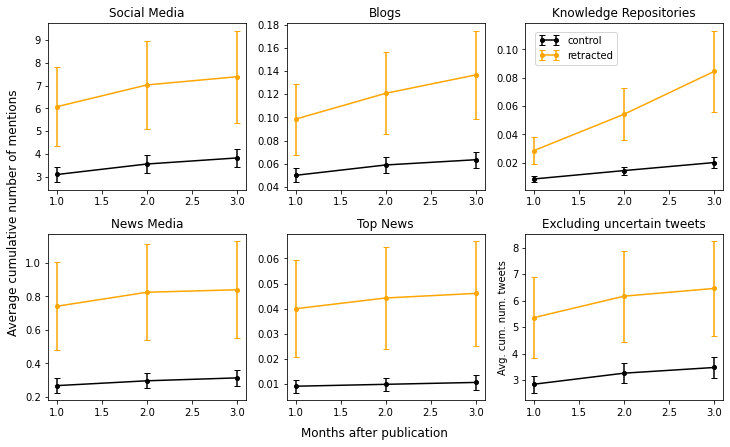

In [81]:
fig, axes = plt.subplots(figsize = (10, 6), nrows=2, ncols=3)

for i, cate in enumerate(cates_names):
    ax = axes[i//3, i%3]
    series_data_control = np.array([ts[i] for ts in series_control_early])
    series_data_retract = np.array([ts[i] for ts in series_retract_early])
    U_test(cate, series_data_control, series_data_retract)
    plot(ax, cate, series_data_control, series_data_retract, how='cumulative', time_type='early')
    if i == 2 or i == 1:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# get uncertainty data
ax = axes[1, 2]
cates = ['uncertainty', 'tw_date_sort']
keys_2, series_retract_early_ = process_df(retract_df, key_col='doi', sliding=slide, length=length)
# exclude control papers for excluded retracted ones.
control_tem = control_df.loc[control_df['matched_retract_doi'].isin(keys_2)]
control_tem.index = range(len(control_tem))
keys_1, series_control_early_ = process_df(control_tem, key_col='altid', sliding=slide, length=length)
ixx = []
for i, doi in enumerate(keys_2):
    keep = False
    for altid in doi_control_aids[doi]:
        if altid in keys_1:
            keep = True
            break
    if keep:
        ixx.append(i)
keys_2 = [keys_2[i] for i in ixx]
series_retract_early_ = series_retract_early_[ixx]
series_data_control = cal_exc_uncertain(series_control_early_)
series_data_retract = cal_exc_uncertain(series_retract_early_)
# data is already cumulative.
plot(ax, 'Excluding critical tweets', series_data_control, series_data_retract, how='normal', time_type='early')
ax.set_ylabel('Avg. cum. num. tweets')
# ax.set_ylim([1.5, 9.8])

fig.text(0.5, -0.02, 'Months after publication', ha='center', fontsize=12)
fig.text(-0.01, 0.5, 'Average cumulative number of mentions', va='center', rotation='vertical', fontsize=12)

legend = axes[0, 2].legend(loc=[0.05, 0.75], numpoints=2, labelspacing = 0.5, fontsize=10, shadow=False, frameon = True)

plt.tight_layout()
plt.show()
fig.savefig('after_pub_mentions_3m.pdf', bbox_inches='tight', pad_inches=0.01)

### After publication - critical tweets

In [85]:
cates = ['uncertainty', 'tw_date_sort']

In [86]:
slide = 30
length = 180

In [87]:
keys_2, series_retract_early = process_df(retract_df, key_col='doi', sliding=slide, length=length)
# exclude control papers for excluded retracted ones.
control_tem = control_df.loc[control_df['matched_retract_doi'].isin(keys_2)]
control_tem.index = range(len(control_tem))
keys_1, series_control_early = process_df(control_tem, key_col='altid', sliding=slide, length=length)

ixx = []
for i, doi in enumerate(keys_2):
    keep = False
    for altid in doi_control_aids[doi]:
        if altid in keys_1:
            keep = True
            break
    if keep:
        ixx.append(i)
        
keys_2 = [keys_2[i] for i in ixx]
series_retract_early = series_retract_early[ixx]

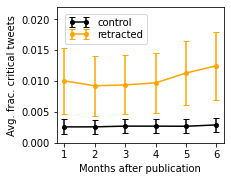

In [625]:
fig, ax = plt.subplots(figsize = (3, 2.5), nrows=1, ncols=1)

# this func calculates cumulative
series_data_control = cal_frac(series_control_early)
series_data_retract = cal_frac(series_retract_early)
# plot(ax, '', series_data_control, series_data_retract, how='normal', time_type='early')

ys_1 = [np.mean(frac) for frac in series_data_control]
stds_1 = [np.std(frac) for frac in series_data_control]
ns_1 = [len(frac) for frac in series_data_control]

ys_2 = [np.mean(frac) for frac in series_data_retract]
stds_2 = [np.std(frac) for frac in series_data_retract]
ns_2 = [len(frac) for frac in series_data_retract]

col1 = 'k' #'#0057e7'
col2 = '#ffa500' #'#d62d20'
xs = np.arange(len(ys_1)) + 1
ax.errorbar(xs, ys_1, yerr=CIs['95']*(stds_1/np.sqrt(ns_1)), color=col1, fmt='-o', markersize=4, capsize=3, label='control')
ax.errorbar(xs, ys_2, yerr=CIs['95']*(stds_2/np.sqrt(ns_2)), color=col2, fmt='-o', markersize=4, capsize=3, label='retracted')

ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_xlabel('Months after publication')
ax.set_ylabel('Avg. frac. critical tweets')
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
ax.set_ylim(0, 0.022)
legend = ax.legend(loc=[0.05, 0.73], numpoints=2, labelspacing = 0.2, shadow=False, frameon = True)
# plt.tight_layout()
plt.show()

fig.savefig('after_pub_uncertain_tw.pdf', bbox_inches='tight', pad_inches=0.02)


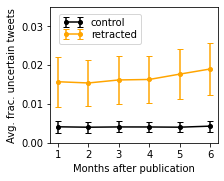

In [504]:
fig, ax = plt.subplots(figsize = (3, 2.5), nrows=1, ncols=1)

# this func calculates cumulative
series_data_control = cal_frac(series_control_early)
series_data_retract = cal_frac(series_retract_early)
# plot(ax, '', series_data_control, series_data_retract, how='normal', time_type='early')

ys_1 = [np.mean(frac) for frac in series_data_control]
stds_1 = [np.std(frac) for frac in series_data_control]
ns_1 = [len(frac) for frac in series_data_control]

ys_2 = [np.mean(frac) for frac in series_data_retract]
stds_2 = [np.std(frac) for frac in series_data_retract]
ns_2 = [len(frac) for frac in series_data_retract]

col1 = 'k' #'#0057e7'
col2 = '#ffa500' #'#d62d20'
xs = np.arange(len(ys_1)) + 1
ax.errorbar(xs, ys_1, yerr=CIs['95']*(stds_1/np.sqrt(ns_1)), color=col1, fmt='-o', markersize=4, capsize=3, label='control')
ax.errorbar(xs, ys_2, yerr=CIs['95']*(stds_2/np.sqrt(ns_2)), color=col2, fmt='-o', markersize=4, capsize=3, label='retracted')

ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_xlabel('Months after publication')
ax.set_ylabel('Avg. frac. critical tweets')
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
ax.set_ylim(0, 0.035)
legend = ax.legend(loc=[0.05, 0.73], numpoints=2, labelspacing = 0.2, shadow=False, frameon = True)
# plt.tight_layout()
plt.show()

fig.savefig('after_pub_uncertain_tw_SI.pdf', bbox_inches='tight', pad_inches=0.02)


### After publication - correlation between critical tweets (fraction) and mention counts in different platforms

In [459]:
slide = 30 # 7 
length = 180
num_ = length//slide

In [460]:
cates = ['uncertainty', 'tw_date_sort']

In [461]:
keys_2, series_retract_early = process_df(retract_df, key_col='doi', sliding=slide, length=length)

In [462]:
nume = np.array([ts[0] for ts in series_retract_early])
deno = np.array([ts[1] for ts in series_retract_early])
nume = np.sum(nume, axis = 1)
deno = np.sum(deno, axis = 1)
dois_, fracs = [], []
tots = []
for doi, a, b in zip(keys_2, nume, deno):
    if b > 0:
        dois_.append(doi)
        fracs.append(a/b)
        tots.append(b)

In [463]:
len(dois_)

1126

In [465]:
cates = ['social_media', 'blog', 'knowledge_repo', 'news_media', 'top_news']
cates_names = ['Social Media', 'Blogs', 'Knowledge Repositories', 'News Media', 'Top News']

In [466]:
retract_df_tem = retract_df.loc[retract_df.OriginalPaperDOI.isin(dois_)]
retract_df_tem.index = range(len(retract_df_tem))
_, series_retract_early = process_df(retract_df_tem, key_col='doi', sliding=slide, length=length)

In [467]:
series_retract_early = np.sum(series_retract_early, axis=2)

In [468]:
series_retract_early.shape

(1126, 5)

Correlation

In [319]:
for i, cate in enumerate(cates_names):
    print(pearsonr(fracs, series_retract_early[:, i]), '\t', cate)

(0.03108649614154023, 0.2973053505590005) 	 Social Media
(0.0190245450159277, 0.5236463014342305) 	 Blogs
(0.005325736129285633, 0.8583202946853636) 	 Knowledge Repositories
(-0.003544299558749926, 0.905433396058191) 	 News Media
(0.001818707306281672, 0.9513905316795767) 	 Top News


### After publication - tw mentions and follower count

In [117]:
def fw_cn_time_freq_helper(row, sdate, sliding, length, time_type):
    date_li, fcn_li = row[['tw_date_sort', 'fcn_date_sort']]
    date_li = [datetime.strptime(dtt, '%Y-%m-%dT%H:%M:%S') for dtt in date_li]
    if time_type == 'early' or time_type == 'after_retract':
        time_segments = get_time_seg(sdate, sdate + dt.timedelta(days = length), sliding)
    if time_type == 'late':
        time_segments = get_time_seg(sdate - dt.timedelta(days = length), sdate, sliding)
    fcn_sum = [0] * len(time_segments)
    men_cn = [0] * len(time_segments)
    date_index = 0
    begin, stop = time_segments[date_index]
    for dtt, fcn in zip(date_li, fcn_li):
        if date_index < len(time_segments):
            arrived = False
            while not arrived:
                if (dtt - begin).total_seconds() >= 0:
                    if (stop - dtt).total_seconds() > 0:
                        arrived = True
                    else:
                        date_index += 1
                        if date_index == len(time_segments):
                            break
                        begin, stop = time_segments[date_index]
                else:
                    break
            if arrived and date_index < len(time_segments):
                fcn_sum[date_index] += fcn
                men_cn[date_index] += 1
    return [fcn_sum, men_cn]
            
def get_time_freq_fw_cn(row, key_col, sliding, length, time_type):
    # first x months after pub_date
    if time_type == 'early':
        if key_col == 'doi':
            # retract usable_days is from pub_date to min(retract_date, alt_end_date).
            pub_date, usable_days = row[['pub_date_corrected', 'usable_days']]
        else:
            # control usable_days is from pub_date to alt_end_date.
            pub_date, usable_days = row[['altmetric_pub_date', 'usable_days']]
        if usable_days >= length:
            return fw_cn_time_freq_helper(row, pub_date, sliding, length, time_type)
        else:
            return []
    # last x months before retract_date
    if time_type == 'late':
        if key_col == 'doi':
            retract_date, usable_days = row[['RetractionDate', 'usable_days']]
            # retract_date has to be before alt_end_date
            if retract_date <= altmetric_end_date and usable_days >= length:
                return fw_cn_time_freq_helper(row, retract_date, sliding, length, time_type)
            else:
                return []
        else:
            alt_id, pub_date, retract_doi = row[['altmetric_id', 'altmetric_pub_date', 'matched_retract_doi']]
            fake_retract_date = doi_ret_date[retract_doi]
            if fake_retract_date <= altmetric_end_date and int((fake_retract_date - pub_date).total_seconds()/day) >= length:
                return fw_cn_time_freq_helper(row, fake_retract_date, sliding, length, time_type)
            else:
                return []
    if time_type == 'after_retract':
        if key_col == 'doi':
            retract_date = row['RetractionDate']
            if int((altmetric_end_date - retract_date).total_seconds()/day) >= length:
                return fw_cn_time_freq_helper(row, retract_date, sliding, length, time_type)
            else:
                return []
        else:
            alt_id, retract_doi = row[['altmetric_id', 'matched_retract_doi']]
            fake_retract_date = doi_ret_date[retract_doi]
            if int((altmetric_end_date - fake_retract_date).total_seconds()/day) >= length:
                return fw_cn_time_freq_helper(row, fake_retract_date, sliding, length, time_type)
            else:
                return []

def process_df_fw_cn(df, key_col, sliding = 30, length = 180, time_type = 'early'):
    series_data = []
    keys = []
    for ix, row in df.iterrows():
        if key_col == 'doi':
            key = row['OriginalPaperDOI']
        if key_col == 'altid':
            key = row['altmetric_id']
        fcns = get_time_freq_fw_cn(row, key_col, sliding, length, time_type)
        if fcns != []:
            series_data.append(fcns)
            keys.append(key)
    return keys, np.array(series_data)

In [118]:
slide = 30 # 7 
length = 180

In [119]:
keys_2, series_retract_early = process_df_fw_cn(retract_df, key_col='doi', sliding=slide, length=length)
control_tem = control_df.loc[control_df['matched_retract_doi'].isin(keys_2)]
control_tem.index = range(len(control_tem))
keys_1, series_control_early = process_df_fw_cn(control_tem, key_col='altid', sliding=slide, length=length)

ixx = []
for i, doi in enumerate(keys_2):
    keep = False
    for altid in doi_control_aids[doi]:
        if altid in keys_1:
            keep = True
            break
    if keep:
        ixx.append(i)
        
keys_2 = [keys_2[i] for i in ixx]
series_retract_early = series_retract_early[ixx]

In [120]:
len(series_retract_early)

2830

In [121]:
len(series_control_early)

13599

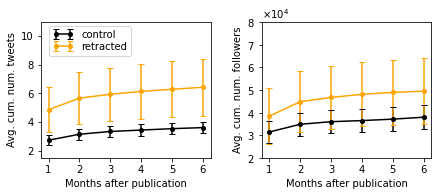

In [123]:
fig, axes = plt.subplots(figsize = (7, 2.5), nrows=1, ncols=2)

series_data_control = np.array([ts[1] for ts in series_control_early])
series_data_retract = np.array([ts[1] for ts in series_retract_early])
    
ax = axes[0]
plot(ax, '', series_data_control, series_data_retract, how='cumulative', time_type='early')
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
ax.set_xlabel('Months after publication')
ax.set_ylabel('Avg. cum. num. tweets')
ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_ylim([1.5, 11])
legend = ax.legend(loc=[0.05, 0.75], numpoints=2, labelspacing = 0.2, shadow=False, frameon = True)

series_data_control = np.array([ts[0] for ts in series_control_early])
series_data_retract = np.array([ts[0] for ts in series_retract_early])

ax = axes[1]
plot(ax, '', series_data_control, series_data_retract, how='cumulative', time_type='early')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
ax.set_xlabel('Months after publication')
ax.set_ylabel('Avg. cum. num. followers')
ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_ylim([2e4, 8e4])

plt.subplots_adjust(wspace=0.3)
plt.show()
fig.savefig('after_pub_tw_follower.pdf', bbox_inches='tight', pad_inches=0.01)

### Before retraction - all platforms

(1) Fraction of papers that are dead before retraction (no filtering)

In [124]:
slide = 30
length = 180

In [125]:
cates = ['social_media', 'blog', 'knowledge_repo', 'news_media', 'top_news']
cates_names = ['Social Media', 'Blogs', 'Knowledge Repositories', 'News Media', 'Top News']

In [126]:
keys_2, series_retract_late = process_df(retract_df, key_col='doi', sliding=slide, length=length, time_type='late')

In [127]:
cn = 0
for tss in series_retract_late:
    if np.sum(tss[:4, :]) == 0:
        cn += 1

In [128]:
cn/len(series_retract_late)

0.8019607843137255

In [129]:
cn = 0
for tss in series_retract_late:
    if np.sum(tss[:4, -1:]) == 0:
        cn += 1

In [130]:
cn/len(series_retract_late)

0.9356862745098039

(2) Fraction of last month mentions over all mentions from pub to ret (no filtering of uncertainty)

In [131]:
slide = 30
cates = ['social_media', 'blog', 'knowledge_repo', 'news_media', 'top_news']
cates_names = ['Social Media', 'Blogs', 'Knowledge Repositories', 'News Media', 'Top News']

In [132]:
totals = {}
for ix, row in retract_df.iterrows():
    tot = 0
    doi, retract_date, usable_days = row[['OriginalPaperDOI', 'RetractionDate', 'usable_days']].values.flatten()
    for date_li in row[cates[:4]].values.flatten():
        date_li = [datetime.strptime(dtt, '%Y-%m-%dT%H:%M:%S') for dtt in date_li]
        for dtt in date_li:
            if dtt <= retract_date:
                tot += 1
    totals[doi] = tot

In [133]:
len(totals)

3659

In [134]:
fracs_ = []
# don't use np.arange here
for i in range(0, 60, 6):
    length = slide * (i+1)
    keys_2, series_retract_late = process_df(retract_df, key_col='doi', sliding=slide, length=length, length_type='exact_months', time_type='late')
    # mentions in the last month
    series_retract_late = [np.sum(tss[:4, -1:]) for tss in series_retract_late]
    tots = [totals[doi] for doi in keys_2]
    frac = []
    for tss, tot in zip(series_retract_late, tots):
        # focus on papers with at least 1 total mention between pub to retraction.
        if tot > 0:
            frac.append(tss/tot)
    fracs_.append(frac)
    

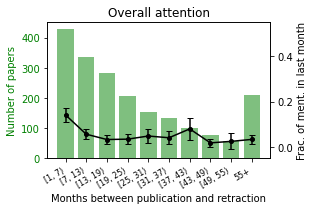

In [135]:
fig, ax = plt.subplots(figsize = (4, 2.5), nrows=1, ncols=1)

ys = [np.mean(frac) for frac in fracs_]
stds = [np.std(frac) for frac in fracs_]
ns = [len(frac) for frac in fracs_]
xs = np.arange(len(ys)) + 1
col1 = 'k' #'#0057e7'
# col2 = '#ffa500' #'#d62d20'


ax.bar(xs, ns, color='g', alpha=0.5)
ax.set_ylabel('Number of papers', color='green')
ax.tick_params(axis='y', labelcolor = 'green')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax.set_xticklabels(['[1, 7)', '[7, 13)', '[13, 19)', '[19, 25)', '[25, 31)', '[31, 37)', '[37, 43)', '[43, 49)', \
                    '[49, 55)', '55+'])
for tick in ax.get_xticklabels():
    tick.set_ha('right')
    tick.set_fontsize(8)
    tick.set_rotation(30)
ax.set_title('Overall attention')
ax.set_xlabel('Months between publication and retraction')

ax2 = ax.twinx()
ax2.errorbar(xs, ys, yerr=CIs['95']*(stds/np.sqrt(ns)), color=col1, fmt='-o', markersize=4, capsize=3)
ax2.set_ylim([-0.05, 0.55])
ax2.set_ylabel('Frac. of ment. in last month')

# ys = [np.mean(frac) for frac in fracs]
# stds = [np.std(frac) for frac in fracs]
# ns = [len(frac) for frac in fracs]
# xs = np.arange(len(ys)) + 1
# # col2 = '#0057e7'
# ax2.errorbar(xs, ys, yerr=CIs['95']*(stds/np.sqrt(ns)), color=col1, fmt='-v', markersize=5, capsize=3, label='Twitter attention w/o uncertainty')

# legend = ax2.legend(loc=[0.2, 0.75], numpoints=2, labelspacing = 0.2, shadow=False, frameon = True)
plt.show()
fig.savefig('last_month_fraction.pdf', bbox_inches='tight', pad_inches=0.02)

In [136]:
ns

[429, 336, 281, 206, 152, 134, 101, 77, 58, 211]

(3) Remove posts with "retract" (will be combined with the post retraction period)

In [940]:
# slide = 30
# length = 180

In [137]:
slide = 7
length = 60

In [559]:
slide = 7
length = 30

In [560]:
cates = ['social_media', 'blog', 'knowledge_repo', 'news_media', 'top_news']
cates_names = ['Social Media', 'Blogs', 'Knowledge Repositories', 'News Media', 'Top News']

In [561]:
keys_2, series_retract_late = process_df(retract_df_filter, key_col='doi', sliding=slide, length=length, time_type='late')
control_tem = control_df_filter.loc[control_df_filter['matched_retract_doi'].isin(keys_2)]
control_tem.index = range(len(control_tem))
keys_1, series_control_late = process_df(control_tem, key_col='altid', sliding=slide, length=length, time_type='late')

ixx = []
for i, doi in enumerate(keys_2):
    keep = False
    for altid in doi_control_aids[doi]:
        if altid in keys_1:
            keep = True
            break
    if keep:
        ixx.append(i)
        
keys_2 = [keys_2[i] for i in ixx]
series_retract_late = series_retract_late[ixx]

In [140]:
len(series_control_late)

11352

In [141]:
len(series_retract_late)

2973

### After retraction

All platform (exclude "retract" and manually labeled retraction discussion posts)

In [206]:
# slide = 30
# length = 180

In [142]:
slide = 7
length = 60

In [553]:
# slide = 7
# length = 30

In [554]:
cates = ['social_media', 'blog', 'knowledge_repo', 'news_media', 'top_news']
cates_names = ['Social Media', 'Blogs', 'Knowledge Repositories', 'News Media', 'Top News']

In [555]:
keys_2_, series_retract_after = process_df(retract_df, key_col='doi', sliding=slide, length=length, time_type='after_retract')
# excluding retraction notification posts
keys_3_, series_retract_after_filter = process_df(retract_df_filter, key_col='doi', sliding=slide, length=length, time_type='after_retract')
control_tem = control_df_filter.loc[control_df_filter['matched_retract_doi'].isin(keys_3_)]
control_tem.index = range(len(control_tem))
keys_1_, series_control_after_filter = process_df(control_tem, key_col='altid', sliding=slide, length=length, time_type='after_retract')

ixx = []
for i, doi in enumerate(keys_3_):
    keep = False
    for altid in doi_control_aids[doi]:
        if altid in keys_1_:
            keep = True
            break
    if keep:
        ixx.append(i)
        
keys_3_ = [keys_3_[i] for i in ixx]
series_retract_after_filter = series_retract_after_filter[ixx]


ixx = []
for i, doi in enumerate(keys_2_):
    keep = False
    for altid in doi_control_aids[doi]:
        if altid in keys_1_:
            keep = True
            break
    if keep:
        ixx.append(i)
        
keys_2_ = [keys_2_[i] for i in ixx]
series_retract_after = series_retract_after[ixx]

In [145]:
len(series_retract_after)

3225

In [146]:
len(series_retract_after_filter)

3225

In [147]:
len(series_control_after_filter)

15659

avg. total mentions (Retract vs. Control): 2.850 vs. 0.583 (p = 0.000); U-test: p = 0.000 (Social Media)
avg. total mentions (Retract vs. Control): 0.388 vs. 0.583 (p = 0.406); U-test: p = 0.040 (Social Media)

avg. total mentions (Retract vs. Control): 0.365 vs. 0.010 (p = 0.000); U-test: p = 0.000 (Blogs)
avg. total mentions (Retract vs. Control): 0.012 vs. 0.010 (p = 0.726); U-test: p = 0.934 (Blogs)

avg. total mentions (Retract vs. Control): 0.165 vs. 0.013 (p = 0.000); U-test: p = 0.000 (Knowledge Repositories)
avg. total mentions (Retract vs. Control): 0.011 vs. 0.013 (p = 0.533); U-test: p = 0.104 (Knowledge Repositories)

avg. total mentions (Retract vs. Control): 0.200 vs. 0.032 (p = 0.000); U-test: p = 0.000 (News Media)
avg. total mentions (Retract vs. Control): 0.032 vs. 0.032 (p = 0.977); U-test: p = 0.614 (News Media)

avg. total mentions (Retract vs. Control): 0.018 vs. 0.001 (p = 0.000); U-test: p = 0.000 (Top News)
avg. total mentions (Retract vs. Control): 0.003 vs. 

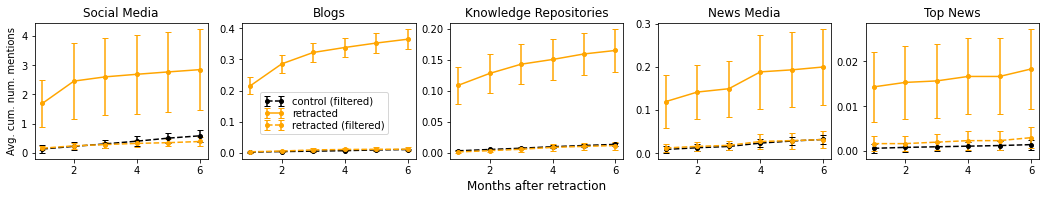

In [209]:
# this is a 6-month time window after retraction

fig, axes = plt.subplots(figsize = (18, 2.5), nrows=1, ncols=5)

for i, cate in enumerate(cates_names):
    ax = axes[i]
    series_data_control_filter = np.array([ts[i] for ts in series_control_after_filter])
    series_data_retract = np.array([ts[i] for ts in series_retract_after])
    series_data_retract_filter = np.array([ts[i] for ts in series_retract_after_filter])
    U_test(cate, series_data_control_filter, series_data_retract)
    U_test(cate, series_data_control_filter, series_data_retract_filter)
    print()
    plot_after(ax, cate, series_data_control_filter, series_data_retract, series_data_retract_filter)
    if i == 4:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[0].set_ylabel('Avg. cum. num. mentions')
axes[2].set_xlabel('Months after retraction', fontsize=12)

legend = axes[1].legend(loc=[0.1, 0.18], numpoints=2, labelspacing = 0.2, shadow=False, frameon = True)
plt.show()
fig.savefig('after_ret_mentions_6m.pdf', bbox_inches='tight', pad_inches=0.01)

### Combine before and after retraction trajectory

In [564]:
late_control_dict = {}
for aid, lli in zip(keys_1, series_control_late):
    late_control_dict[aid] = lli
    
late_retract_dict = {}
for doi, lli in zip(keys_2, series_retract_late):
    late_retract_dict[doi] = lli

In [565]:
after_filter_control_dict = {}
for aid, lli in zip(keys_1_, series_control_after_filter):
    after_filter_control_dict[aid] = lli
    
after_filter_retract_dict = {}
for doi, lli in zip(keys_3_, series_retract_after_filter):
    after_filter_retract_dict[doi] = lli

In [151]:
len(late_control_dict)

11352

In [152]:
len(late_retract_dict)

2973

In [153]:
len(after_filter_control_dict)

15659

In [154]:
len(after_filter_retract_dict)

3225

In [570]:
comb_series_control_filter = []
comb_series_retract_filter = []

for aid in late_control_dict:
    if aid in after_filter_control_dict:
        pre_li = late_control_dict[aid]
        pos_li = after_filter_control_dict[aid]
        res = np.concatenate((pre_li, pos_li), axis = 1)
        comb_series_control_filter.append(res)
        
for doi in late_retract_dict:
    if doi in after_filter_retract_dict:
        pre_li = late_retract_dict[doi]
        pos_li = after_filter_retract_dict[doi]
        res = np.concatenate((pre_li, pos_li), axis = 1)
        comb_series_retract_filter.append(res)

In [156]:
len(comb_series_control_filter)

10969

In [157]:
len(comb_series_retract_filter)

2894

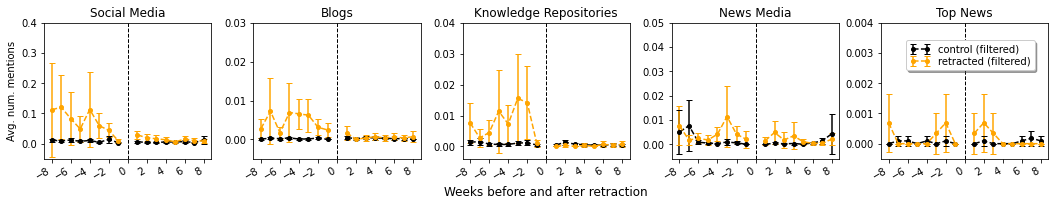

In [167]:
### 2-month prior and post retraction version for monthly count.

fig, axes = plt.subplots(figsize = (18, 2.5), nrows=1, ncols=5)

for i, cate in enumerate(cates_names):
    ax = axes[i]
    series_data_control = np.array([ts[i] for ts in comb_series_control_filter])
    # series_data_retract = np.array([ts[i] for ts in comb_series_retract])
    series_data_retract_filter = np.array([ts[i] for ts in comb_series_retract_filter])
    col1 = 'k' #'#0057e7'
    col2 = '#ffa500' #'#d62d20'
    ys_1 = np.mean(series_data_control[:, 1:9], axis=0)
    std_1 = np.std(series_data_control[:, 1:9], axis=0)
    ys_3 = np.mean(series_data_retract_filter[:, 1:9], axis=0)
    std_3 = np.std(series_data_retract_filter[:, 1:9], axis=0)
    xs = [-8, -7, -6, -5, -4, -3, -2, -1]
    ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(series_data_control))), color=col1, fmt='--o', markersize=4, capsize=3)
    # ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(series_data_retract))), color=col2, fmt='-o', markersize=4, capsize=3)
    ax.errorbar(xs, ys_3, yerr=CIs['95']*(std_3/np.sqrt(len(series_data_retract_filter))), color=col2, fmt='--o', markersize=4, capsize=3)

    ys_1 = np.mean(series_data_control[:, 9:-1], axis=0)
    std_1 = np.std(series_data_control[:, 9:-1], axis=0)
    ys_3 = np.mean(series_data_retract_filter[:, 9:-1], axis=0)
    std_3 = np.std(series_data_retract_filter[:, 9:-1], axis=0)
    xs = [1, 2, 3, 4, 5, 6, 7, 8]
    ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(series_data_control))), color=col1, fmt='--o', markersize=4, capsize=3, label='control (filtered)')
    # ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(series_data_retract))), color=col2, fmt='-o', markersize=4, capsize=3, label='retracted')
    ax.errorbar(xs, ys_3, yerr=CIs['95']*(std_3/np.sqrt(len(series_data_retract_filter))), color=col2, fmt='--o', markersize=4, capsize=3, label='retracted (filtered)')  
    ax.axvline(0, color='k', linestyle='--', linewidth = 1)
    ax.set_title(cate)
    if i == 0:
        ax.set_ylim(-0.05, 0.4)
    if i == 1:
        ax.set_ylim(-0.005, 0.03)
    if i == 2:
        ax.set_ylim(-0.004, 0.04)
    if i == 3:
        ax.set_ylim(-0.006, 0.05)
    if i == 4:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax.set_ylim(-0.0005, 0.004)
    # ax.set_xticks([-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
    ax.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
    for tick in ax.get_xticklabels():
        tick.set_ha('right')
        # tick.set_fontsize(8)
        tick.set_rotation(30)
axes[0].set_ylabel('Avg. num. mentions')
axes[2].set_xlabel('Weeks before and after retraction', fontsize=12)

legend = axes[4].legend(loc=[0.15, 0.65], numpoints=2, labelspacing = 0.2, shadow=True, frameon = True)
plt.subplots_adjust(wspace=0.25)
plt.show()
fig.savefig('before_after_ret_mentions_2m_weekly.pdf', bbox_inches='tight', pad_inches=0.01)

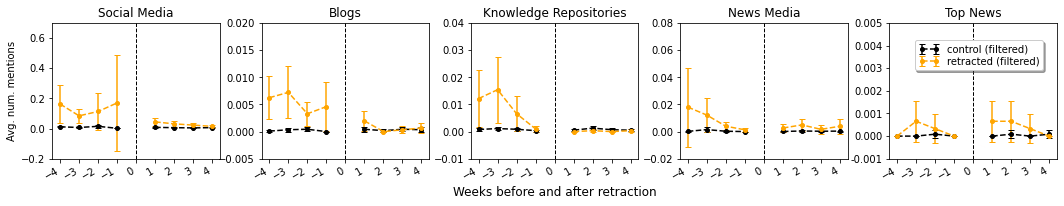

In [580]:
## 1 month prior and post retraction version for weekly count.

fig, axes = plt.subplots(figsize = (18, 2.5), nrows=1, ncols=5)

for i, cate in enumerate(cates_names):
    ax = axes[i]
    series_data_control = np.array([ts[i] for ts in comb_series_control_filter])
    # series_data_retract = np.array([ts[i] for ts in comb_series_retract])
    series_data_retract_filter = np.array([ts[i] for ts in comb_series_retract_filter])
    col1 = 'k' #'#0057e7'
    col2 = '#ffa500' #'#d62d20'
    ys_1 = np.mean(series_data_control[:, 1:5], axis=0)
    std_1 = np.std(series_data_control[:, 1:5], axis=0)
    ys_3 = np.mean(series_data_retract_filter[:, 1:5], axis=0)
    std_3 = np.std(series_data_retract_filter[:, 1:5], axis=0)
    xs = [-4, -3, -2, -1]
    ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(series_data_control))), color=col1, fmt='--o', markersize=4, capsize=3)
    # ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(series_data_retract))), color=col2, fmt='-o', markersize=4, capsize=3)
    ax.errorbar(xs, ys_3, yerr=CIs['95']*(std_3/np.sqrt(len(series_data_retract_filter))), color=col2, fmt='--o', markersize=4, capsize=3)

    ys_1 = np.mean(series_data_control[:, 5:-1], axis=0)
    std_1 = np.std(series_data_control[:, 5:-1], axis=0)
    ys_3 = np.mean(series_data_retract_filter[:, 5:-1], axis=0)
    std_3 = np.std(series_data_retract_filter[:, 5:-1], axis=0)
    xs = [1, 2, 3, 4]
    ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(series_data_control))), color=col1, fmt='--o', markersize=4, capsize=3, label='control (filtered)')
    # ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(series_data_retract))), color=col2, fmt='-o', markersize=4, capsize=3, label='retracted')
    ax.errorbar(xs, ys_3, yerr=CIs['95']*(std_3/np.sqrt(len(series_data_retract_filter))), color=col2, fmt='--o', markersize=4, capsize=3, label='retracted (filtered)')  
    ax.axvline(0, color='k', linestyle='--', linewidth = 1)
    ax.set_title(cate)
    if i == 0:
        ax.set_ylim(-0.2, 0.7)
    if i == 1:
        ax.set_ylim(-0.005, 0.02)
    if i == 2:
        ax.set_ylim(-0.01, 0.04)
    if i == 3:
        ax.set_ylim(-0.02, 0.08)
    if i == 4:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax.set_ylim(-0.001, 0.005)
    # ax.set_xticks([-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
    ax.set_xticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
    for tick in ax.get_xticklabels():
        tick.set_ha('right')
        # tick.set_fontsize(8)
        tick.set_rotation(30)
axes[0].set_ylabel('Avg. num. mentions')
axes[2].set_xlabel('Weeks before and after retraction', fontsize=12)

legend = axes[4].legend(loc=[0.15, 0.65], numpoints=2, labelspacing = 0.2, shadow=True, frameon = True)
plt.subplots_adjust(wspace=0.25)
plt.show()
fig.savefig('before_after_ret_mentions_1m_weekly.pdf', bbox_inches='tight', pad_inches=0.01)

#### Four broad disciplines

In [168]:
discs_broad = ['Social Sciences', 'Life Sciences', 'Health Sciences', 'Physical Sciences']

In [169]:
altid_data['1100736']['citation']['scopus_subjects']

['Physical Sciences', 'Computer Science']

In [170]:
doi_alt_data['10.1001/jama.2014.1404']['citation']['scopus_subjects']

['Medicine', 'Health Sciences']

In [171]:
def return_disc_data(disc):
    comb_series_control_filter = []
    comb_series_retract_filter = []

    for aid in late_control_dict:
        if aid in after_filter_control_dict:
            if 'scopus_subjects' in altid_data[aid]['citation']:
                discs = altid_data[aid]['citation']['scopus_subjects']
                if disc in discs:
                    pre_li = late_control_dict[aid]
                    pos_li = after_filter_control_dict[aid]
                    res = np.concatenate((pre_li, pos_li), axis = 1)
                    comb_series_control_filter.append(res)

    for doi in late_retract_dict:
        if doi in after_filter_retract_dict:
            if 'scopus_subjects' in doi_alt_data[doi]['citation']:
                discs = doi_alt_data[doi]['citation']['scopus_subjects']
                if disc in discs:
                    pre_li = late_retract_dict[doi]
                    pos_li = after_filter_retract_dict[doi]
                    res = np.concatenate((pre_li, pos_li), axis = 1)
                    comb_series_retract_filter.append(res)
    return comb_series_retract_filter, comb_series_control_filter

Social Sciences

In [172]:
disc = discs_broad[0]

In [173]:
comb_series_retract_filter, comb_series_control_filter = return_disc_data(disc)

In [174]:
len(comb_series_retract_filter)

131

In [175]:
len(comb_series_control_filter)

470

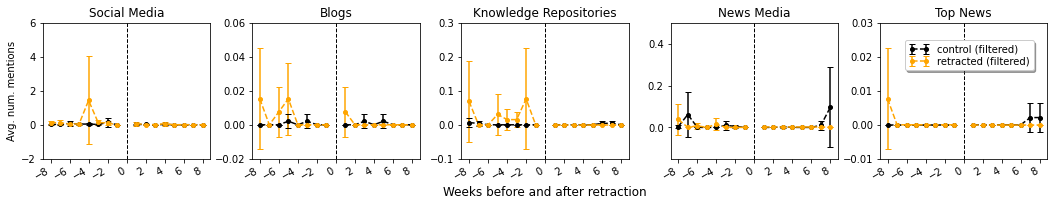

In [178]:
fig, axes = plt.subplots(figsize = (18, 2.5), nrows=1, ncols=5)

for i, cate in enumerate(cates_names):
    ax = axes[i]
    series_data_control = np.array([ts[i] for ts in comb_series_control_filter])
    # series_data_retract = np.array([ts[i] for ts in comb_series_retract])
    series_data_retract_filter = np.array([ts[i] for ts in comb_series_retract_filter])
    col1 = 'k' #'#0057e7'
    col2 = '#ffa500' #'#d62d20'
    ys_1 = np.mean(series_data_control[:, 1:9], axis=0)
    std_1 = np.std(series_data_control[:, 1:9], axis=0)
    ys_3 = np.mean(series_data_retract_filter[:, 1:9], axis=0)
    std_3 = np.std(series_data_retract_filter[:, 1:9], axis=0)
    xs = [-8, -7, -6, -5, -4, -3, -2, -1]
    ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(series_data_control))), color=col1, fmt='--o', markersize=4, capsize=3)
    # ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(series_data_retract))), color=col2, fmt='-o', markersize=4, capsize=3)
    ax.errorbar(xs, ys_3, yerr=CIs['95']*(std_3/np.sqrt(len(series_data_retract_filter))), color=col2, fmt='--o', markersize=4, capsize=3)

    ys_1 = np.mean(series_data_control[:, 9:-1], axis=0)
    std_1 = np.std(series_data_control[:, 9:-1], axis=0)
    ys_3 = np.mean(series_data_retract_filter[:, 9:-1], axis=0)
    std_3 = np.std(series_data_retract_filter[:, 9:-1], axis=0)
    xs = [1, 2, 3, 4, 5, 6, 7, 8]
    ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(series_data_control))), color=col1, fmt='--o', markersize=4, capsize=3, label='control (filtered)')
    # ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(series_data_retract))), color=col2, fmt='-o', markersize=4, capsize=3, label='retracted')
    ax.errorbar(xs, ys_3, yerr=CIs['95']*(std_3/np.sqrt(len(series_data_retract_filter))), color=col2, fmt='--o', markersize=4, capsize=3, label='retracted (filtered)')  
    ax.axvline(0, color='k', linestyle='--', linewidth = 1)
    ax.set_title(cate)
    if i == 0:
        ax.set_ylim(-2, 6)
    if i == 1:
        ax.set_ylim(-0.02, 0.06)
    if i == 2:
        ax.set_ylim(-0.1, 0.3)
    if i == 3:
        ax.set_ylim(-0.15, 0.5)
    if i == 4:
#         ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax.set_ylim(-0.01, 0.03)
    ax.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
    for tick in ax.get_xticklabels():
        tick.set_ha('right')
        # tick.set_fontsize(8)
        tick.set_rotation(30)
axes[0].set_ylabel('Avg. num. mentions')
axes[2].set_xlabel('Weeks before and after retraction', fontsize=12)

legend = axes[4].legend(loc=[0.15, 0.65], numpoints=2, labelspacing = 0.2, shadow=True, frameon = True)
plt.subplots_adjust(wspace=0.25)
plt.show()
fig.savefig('before_after_ret_mentions_2m_weekly_social.pdf', bbox_inches='tight', pad_inches=0.01)

Life Sciences

In [179]:
disc = discs_broad[1]

In [180]:
comb_series_retract_filter, comb_series_control_filter = return_disc_data(disc)

In [181]:
len(comb_series_retract_filter)

1137

In [182]:
len(comb_series_control_filter)

4423

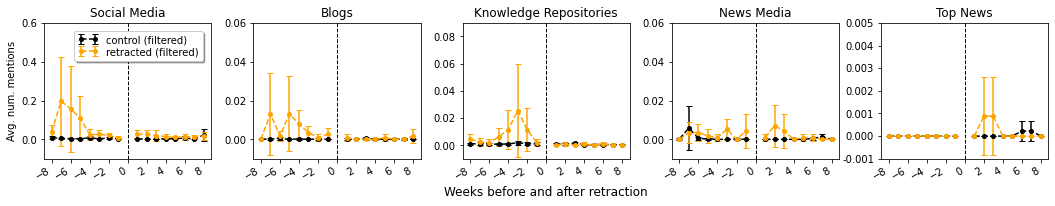

In [185]:
fig, axes = plt.subplots(figsize = (18, 2.5), nrows=1, ncols=5)

for i, cate in enumerate(cates_names):
    ax = axes[i]
    series_data_control = np.array([ts[i] for ts in comb_series_control_filter])
    # series_data_retract = np.array([ts[i] for ts in comb_series_retract])
    series_data_retract_filter = np.array([ts[i] for ts in comb_series_retract_filter])
    col1 = 'k' #'#0057e7'
    col2 = '#ffa500' #'#d62d20'
    ys_1 = np.mean(series_data_control[:, 1:9], axis=0)
    std_1 = np.std(series_data_control[:, 1:9], axis=0)
    ys_3 = np.mean(series_data_retract_filter[:, 1:9], axis=0)
    std_3 = np.std(series_data_retract_filter[:, 1:9], axis=0)
    xs = [-8, -7, -6, -5, -4, -3, -2, -1]
    ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(series_data_control))), color=col1, fmt='--o', markersize=4, capsize=3)
    # ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(series_data_retract))), color=col2, fmt='-o', markersize=4, capsize=3)
    ax.errorbar(xs, ys_3, yerr=CIs['95']*(std_3/np.sqrt(len(series_data_retract_filter))), color=col2, fmt='--o', markersize=4, capsize=3)

    ys_1 = np.mean(series_data_control[:, 9:-1], axis=0)
    std_1 = np.std(series_data_control[:, 9:-1], axis=0)
    ys_3 = np.mean(series_data_retract_filter[:, 9:-1], axis=0)
    std_3 = np.std(series_data_retract_filter[:, 9:-1], axis=0)
    xs = [1, 2, 3, 4, 5, 6, 7, 8]
    ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(series_data_control))), color=col1, fmt='--o', markersize=4, capsize=3, label='control (filtered)')
    # ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(series_data_retract))), color=col2, fmt='-o', markersize=4, capsize=3, label='retracted')
    ax.errorbar(xs, ys_3, yerr=CIs['95']*(std_3/np.sqrt(len(series_data_retract_filter))), color=col2, fmt='--o', markersize=4, capsize=3, label='retracted (filtered)')  
    ax.axvline(0, color='k', linestyle='--', linewidth = 1)
    ax.set_title(cate)
    if i == 0:
        ax.set_ylim(-0.1, 0.6)
    if i == 1:
        ax.set_ylim(-0.01, 0.06)
    if i == 2:
        ax.set_ylim(-0.01, 0.09)
    if i == 3:
        ax.set_ylim(-0.01, 0.06)
    if i == 4:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax.set_ylim(-0.001, 0.005)
    ax.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
    for tick in ax.get_xticklabels():
        tick.set_ha('right')
        # tick.set_fontsize(8)
        tick.set_rotation(30)
axes[0].set_ylabel('Avg. num. mentions')
axes[2].set_xlabel('Weeks before and after retraction', fontsize=12)

legend = axes[0].legend(loc=[0.18, 0.72], numpoints=2, labelspacing = 0.2, shadow=True, frameon = True)
plt.subplots_adjust(wspace=0.25)
plt.show()
fig.savefig('before_after_ret_mentions_2m_weekly_life.pdf', bbox_inches='tight', pad_inches=0.01)

Health Sciences

In [186]:
disc = discs_broad[2]

In [187]:
comb_series_retract_filter, comb_series_control_filter = return_disc_data(disc)

In [188]:
len(comb_series_retract_filter)

993

In [189]:
len(comb_series_control_filter)

3780

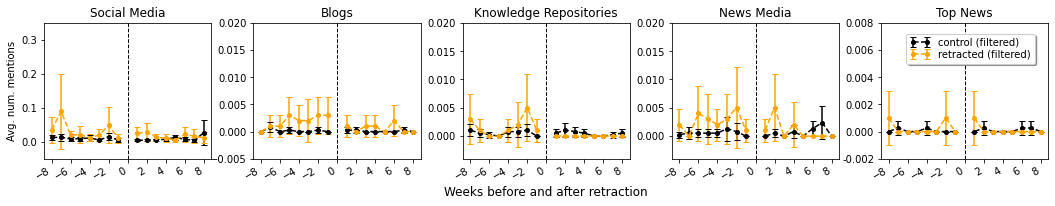

In [192]:
fig, axes = plt.subplots(figsize = (18, 2.5), nrows=1, ncols=5)

for i, cate in enumerate(cates_names):
    ax = axes[i]
    series_data_control = np.array([ts[i] for ts in comb_series_control_filter])
    # series_data_retract = np.array([ts[i] for ts in comb_series_retract])
    series_data_retract_filter = np.array([ts[i] for ts in comb_series_retract_filter])
    col1 = 'k' #'#0057e7'
    col2 = '#ffa500' #'#d62d20'
    ys_1 = np.mean(series_data_control[:, 1:9], axis=0)
    std_1 = np.std(series_data_control[:, 1:9], axis=0)
    ys_3 = np.mean(series_data_retract_filter[:, 1:9], axis=0)
    std_3 = np.std(series_data_retract_filter[:, 1:9], axis=0)
    xs = [-8, -7, -6, -5, -4, -3, -2, -1]
    ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(series_data_control))), color=col1, fmt='--o', markersize=4, capsize=3)
    # ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(series_data_retract))), color=col2, fmt='-o', markersize=4, capsize=3)
    ax.errorbar(xs, ys_3, yerr=CIs['95']*(std_3/np.sqrt(len(series_data_retract_filter))), color=col2, fmt='--o', markersize=4, capsize=3)

    ys_1 = np.mean(series_data_control[:, 9:-1], axis=0)
    std_1 = np.std(series_data_control[:, 9:-1], axis=0)
    ys_3 = np.mean(series_data_retract_filter[:, 9:-1], axis=0)
    std_3 = np.std(series_data_retract_filter[:, 9:-1], axis=0)
    xs = [1, 2, 3, 4, 5, 6, 7, 8]
    ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(series_data_control))), color=col1, fmt='--o', markersize=4, capsize=3, label='control (filtered)')
    # ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(series_data_retract))), color=col2, fmt='-o', markersize=4, capsize=3, label='retracted')
    ax.errorbar(xs, ys_3, yerr=CIs['95']*(std_3/np.sqrt(len(series_data_retract_filter))), color=col2, fmt='--o', markersize=4, capsize=3, label='retracted (filtered)')  
    ax.axvline(0, color='k', linestyle='--', linewidth = 1)
    ax.set_title(cate)
    if i == 0:
        ax.set_ylim(-0.05, 0.35)
    if i == 1:
        ax.set_ylim(-0.005, 0.02)
    if i == 2:
        ax.set_ylim(-0.004, 0.02)
    if i == 3:
        ax.set_ylim(-0.004, 0.02)
    if i == 4:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax.set_ylim(-0.002, 0.008)
    ax.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
    for tick in ax.get_xticklabels():
        tick.set_ha('right')
        # tick.set_fontsize(8)
        tick.set_rotation(30)
axes[0].set_ylabel('Avg. num. mentions')
axes[2].set_xlabel('Weeks before and after retraction', fontsize=12)

legend = axes[4].legend(loc=[0.15, 0.7], numpoints=2, labelspacing = 0.2, shadow=True, frameon = True)
plt.subplots_adjust(wspace=0.25)
plt.show()
fig.savefig('before_after_ret_mentions_2m_weekly_health.pdf', bbox_inches='tight', pad_inches=0.01)

Physical Sciences

In [193]:
disc = discs_broad[3]

In [194]:
comb_series_retract_filter, comb_series_control_filter = return_disc_data(disc)

In [195]:
len(comb_series_retract_filter)

669

In [196]:
len(comb_series_control_filter)

2524

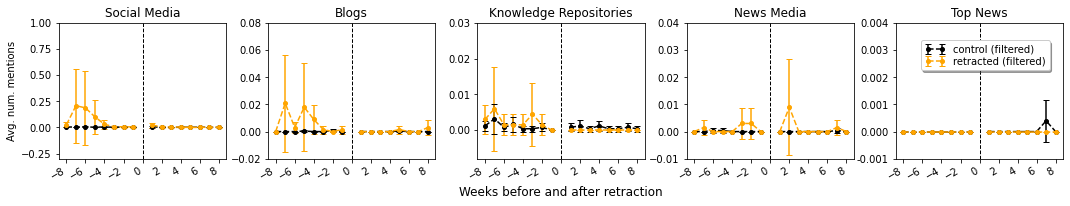

In [199]:
fig, axes = plt.subplots(figsize = (18, 2.5), nrows=1, ncols=5)

for i, cate in enumerate(cates_names):
    ax = axes[i]
    series_data_control = np.array([ts[i] for ts in comb_series_control_filter])
    # series_data_retract = np.array([ts[i] for ts in comb_series_retract])
    series_data_retract_filter = np.array([ts[i] for ts in comb_series_retract_filter])
    col1 = 'k' #'#0057e7'
    col2 = '#ffa500' #'#d62d20'
    ys_1 = np.mean(series_data_control[:, 1:9], axis=0)
    std_1 = np.std(series_data_control[:, 1:9], axis=0)
    ys_3 = np.mean(series_data_retract_filter[:, 1:9], axis=0)
    std_3 = np.std(series_data_retract_filter[:, 1:9], axis=0)
    xs = [-8, -7, -6, -5, -4, -3, -2, -1]
    ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(series_data_control))), color=col1, fmt='--o', markersize=4, capsize=3)
    # ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(series_data_retract))), color=col2, fmt='-o', markersize=4, capsize=3)
    ax.errorbar(xs, ys_3, yerr=CIs['95']*(std_3/np.sqrt(len(series_data_retract_filter))), color=col2, fmt='--o', markersize=4, capsize=3)

    ys_1 = np.mean(series_data_control[:, 9:-1], axis=0)
    std_1 = np.std(series_data_control[:, 9:-1], axis=0)
    ys_3 = np.mean(series_data_retract_filter[:, 9:-1], axis=0)
    std_3 = np.std(series_data_retract_filter[:, 9:-1], axis=0)
    xs = [1, 2, 3, 4, 5, 6, 7, 8]
    ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(series_data_control))), color=col1, fmt='--o', markersize=4, capsize=3, label='control (filtered)')
    # ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(series_data_retract))), color=col2, fmt='-o', markersize=4, capsize=3, label='retracted')
    ax.errorbar(xs, ys_3, yerr=CIs['95']*(std_3/np.sqrt(len(series_data_retract_filter))), color=col2, fmt='--o', markersize=4, capsize=3, label='retracted (filtered)')  
    ax.axvline(0, color='k', linestyle='--', linewidth = 1)
    ax.set_title(cate)
    if i == 0:
        ax.set_ylim(-0.3, 1)
    if i == 1:
        ax.set_ylim(-0.02, 0.08)
    if i == 2:
        ax.set_ylim(-0.008, 0.03)
    if i == 3:
        ax.set_ylim(-0.01, 0.04)
    if i == 4:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax.set_ylim(-0.001, 0.004)
    ax.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
    for tick in ax.get_xticklabels():
        tick.set_ha('right')
        # tick.set_fontsize(8)
        tick.set_rotation(30)
axes[0].set_ylabel('Avg. num. mentions')
axes[2].set_xlabel('Weeks before and after retraction', fontsize=12)

legend = axes[4].legend(loc=[0.15, 0.65], numpoints=2, labelspacing = 0.2, shadow=True, frameon = True)
plt.subplots_adjust(wspace=0.25)
plt.show()
fig.savefig('before_after_ret_mentions_2m_weekly_physical.pdf', bbox_inches='tight', pad_inches=0.01)

### Before retraction - tw mentions

Fraction of last month tweets over all tweets from pub to ret (exclude only critical tweets)

In [656]:
slide = 30
cates = ['uncertainty', 'tw_date_sort']

In [657]:
for doi in retract_df_filter['OriginalPaperDOI']:
    retract_date = doi_ret_date[doi]
    paper = doi_alt_data[doi]
    tot = 0
    if 'posts' in paper and 'twitter' in paper['posts']:
        for item in paper['posts']['twitter']:
            tid = item['tweet_id']
            if tid in tid_date and tid not in uncertain_tids:
                dtt = tid_date[tid]
                dtt = datetime.strptime(dtt, '%Y-%m-%dT%H:%M:%S')
                if dtt <= retract_date:
                    tot += 1
    totals[doi] = tot

In [658]:
len(totals)

3659

In [659]:
fracs = []
for i in range(0, 60, 6):
    length = slide * (i+1)
    keys_2, series_retract_late = process_df(retract_df, key_col='doi', sliding=slide, length=length, length_type='exact_months', time_type='late')
    series_retract_late = cal_exc_uncertain(series_retract_late, how='per_window')
    # mentions in the last month
    series_retract_late = [tss[-1] for tss in series_retract_late]
    tots = [totals[doi] for doi in keys_2]
    frac = []
    for tss, tot in zip(series_retract_late, tots):
        # focus on papers with at least 1 total mention between pub to retraction.
        if tot > 0:
            frac.append(tss/tot)
    fracs.append(frac)

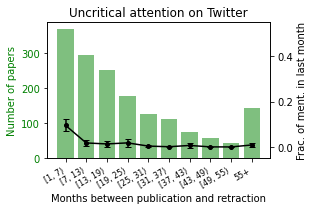

In [660]:
fig, ax = plt.subplots(figsize = (4, 2.5), nrows=1, ncols=1)

ys = [np.mean(frac) for frac in fracs]
stds = [np.std(frac) for frac in fracs]
ns = [len(frac) for frac in fracs]
xs = np.arange(len(ys)) + 1

ax.bar(xs, ns, color='g', alpha=0.5)
ax.set_ylabel('Number of papers', color='green')
ax.tick_params(axis='y', labelcolor = 'green')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax.set_xticklabels(['[1, 7)', '[7, 13)', '[13, 19)', '[19, 25)', '[25, 31)', '[31, 37)', '[37, 43)', '[43, 49)', \
                    '[49, 55)', '55+'])
for tick in ax.get_xticklabels():
    tick.set_ha('right')
    tick.set_fontsize(8)
    tick.set_rotation(30)
ax.set_title('Uncritical attention on Twitter')
ax.set_xlabel('Months between publication and retraction')

ax2 = ax.twinx()
ax2.errorbar(xs, ys, yerr=CIs['95']*(stds/np.sqrt(ns)), color=col1, fmt='-o', markersize=4, capsize=3)
ax2.set_ylim([-0.05, 0.55])
ax2.set_ylabel('Frac. of ment. in last month')

# legend = ax2.legend(loc=[0.2, 0.75], numpoints=2, labelspacing = 0.2, shadow=False, frameon = True)
plt.show()
fig.savefig('last_month_fraction_tw.pdf', bbox_inches='tight', pad_inches=0.02)

In [205]:
ns

[368, 295, 252, 177, 128, 111, 76, 57, 42, 142]

Exclude posts with the "retract" keyword and critical tweets (will be combined with after-retraction for ITS analysis)

In [210]:
slide = 7 
length = 60

In [1423]:
# slide = 30
# length = 180

In [211]:
cates = ['uncertainty', 'tw_date_sort']

In [212]:
keys_2, series_retract_late = process_df(retract_df_filter, key_col='doi', sliding=slide, length=length, time_type='late')
control_tem = control_df_filter.loc[control_df_filter['matched_retract_doi'].isin(keys_2)]
control_tem.index = range(len(control_tem))
keys_1, series_control_late = process_df(control_tem, key_col='altid', sliding=slide, length=length, time_type='late')

ixx = []
for i, doi in enumerate(keys_2):
    keep = False
    for altid in doi_control_aids[doi]:
        if altid in keys_1:
            keep = True
            break
    if keep:
        ixx.append(i)
        
keys_2 = [keys_2[i] for i in ixx]
series_retract_late = series_retract_late[ixx]

In [213]:
series_control_late = cal_exc_uncertain(series_control_late, how='per_window')
series_retract_late = cal_exc_uncertain(series_retract_late, how='per_window')

In [214]:
len(keys_2)

2973

In [215]:
series_retract_late[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

### After retraction - tw mentions

Exclude posts with "retract" keyword and manually labeled retraction-dicussion posts

In [216]:
slide = 7 
length = 60

In [217]:
# slide = 30
# length = 180

In [218]:
keys_3_, series_retract_after_filter = process_df_fw_cn(retract_df_filter, key_col='doi', sliding=slide, length=length, time_type='after_retract')
control_tem = control_df_filter.loc[control_df_filter['matched_retract_doi'].isin(keys_3_)]
control_tem.index = range(len(control_tem))
keys_1_, series_control_after = process_df_fw_cn(control_tem, key_col='altid', sliding=slide, length=length, time_type='after_retract')

ixx = []
for i, doi in enumerate(keys_3_):
    keep = False
    for altid in doi_control_aids[doi]:
        if altid in keys_1_:
            keep = True
            break
    if keep:
        ixx.append(i)
        
keys_3_ = [keys_3_[i] for i in ixx]
series_retract_after_filter = series_retract_after_filter[ixx]

In [219]:
series_retract_after_filter[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

### Interrupted time series analysis (twitter)

In [220]:
series_control_after = np.array([ts[1] for ts in series_control_after])
series_retract_after_filter = np.array([ts[1] for ts in series_retract_after_filter])

In [221]:
after_control_dict = {}
for aid, lli in zip(keys_1_, series_control_after):
    after_control_dict[aid] = lli
    
after_filter_retract_dict = {}
for doi, lli in zip(keys_3_, series_retract_after_filter):
    after_filter_retract_dict[doi] = lli

In [222]:
late_control_dict = {}
for aid, lli in zip(keys_1, series_control_late):
#     if np.sum(lli) > 0:
    late_control_dict[aid] = lli
    
late_retract_dict = {}
for doi, lli in zip(keys_2, series_retract_late):
#     if np.sum(lli) > 0:
    late_retract_dict[doi] = lli

In [223]:
len(late_control_dict)

11352

In [224]:
len(late_retract_dict)

2973

In [225]:
len(after_control_dict)

15659

In [226]:
len(after_filter_retract_dict)

3225

In [227]:
comb_series_control = []
comb_series_retract = []

for aid in late_control_dict:
    if aid in after_control_dict:
        pre_li = late_control_dict[aid]
        pos_li = after_control_dict[aid]
        res = np.concatenate([pre_li, pos_li])
        comb_series_control.append(res)

for doi in late_retract_dict:
    if doi in after_filter_retract_dict:
        pre_li = late_retract_dict[doi]
        pos_li = after_filter_retract_dict[doi]
        res = np.concatenate([pre_li, pos_li])
        comb_series_retract.append(res)

In [228]:
len(comb_series_retract)

2894

In [229]:
comb_series_control = np.array(comb_series_control)
comb_series_retract = np.array(comb_series_retract)

In [230]:
comb_series_control[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

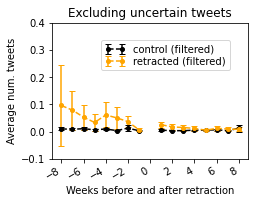

In [238]:
fig, ax = plt.subplots(figsize = (3.5, 2.5), nrows=1, ncols=1)

col1 = 'k'
col2 = '#ffa500'

ys_1 = np.mean(comb_series_control[:, 1:9], axis=0)
std_1 = np.std(comb_series_control[:, 1:9], axis=0)
ys_2 = np.mean(comb_series_retract[:, 1:9], axis=0)
std_2 = np.std(comb_series_retract[:, 1:9], axis=0)
xs = [-8, -7, -6, -5, -4, -3, -2, -1]
ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(comb_series_control))), color=col1, fmt='--o', markersize=4, capsize=3)
ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(comb_series_retract))), color=col2, fmt='--o', markersize=4, capsize=3)

ys_1 = np.mean(comb_series_control[:, 9:-1], axis=0)
std_1 = np.std(comb_series_control[:, 9:-1], axis=0)
ys_2 = np.mean(comb_series_retract[:, 9:-1], axis=0)
std_2 = np.std(comb_series_retract[:, 9:-1], axis=0)
xs = [1, 2, 3, 4, 5, 6, 7, 8]
ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(comb_series_control))), color=col1, fmt='--o', markersize=4, capsize=3, label="control (filtered)")
ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(comb_series_retract))), color=col2, fmt='--o', markersize=4, capsize=3, label="retracted (filtered)")

# ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
ax.set_xlabel('Weeks before and after retraction')
ax.set_ylabel('Average num. tweets')
ax.set_ylim([-0.1, 0.4])
ax.set_title('Excluding critical tweets')
for tick in ax.get_xticklabels():
    tick.set_ha('right')
    # tick.set_fontsize(8)
    tick.set_rotation(30)
legend = ax.legend(loc=[0.25, 0.65], numpoints=2, labelspacing = 0.2, shadow=False, frameon = True)
plt.show()
fig.savefig('ITS_tw.pdf', bbox_inches='tight', pad_inches=0.01)

Avg time series for retracted papers (without control) - weekly count for 2-month pre/post retraction time window

In [239]:
# it has 9 weeks before/after, we exclude the first and the last week to focus on the 2-month before/after window
y = np.mean(comb_series_retract[:, 1:-1], axis=0)

In [240]:
X = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
             [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
             [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8]]).T

In [241]:
X

array([[ 1,  0,  0],
       [ 2,  0,  0],
       [ 3,  0,  0],
       [ 4,  0,  0],
       [ 5,  0,  0],
       [ 6,  0,  0],
       [ 7,  0,  0],
       [ 8,  0,  0],
       [ 9,  1,  1],
       [10,  1,  2],
       [11,  1,  3],
       [12,  1,  4],
       [13,  1,  5],
       [14,  1,  6],
       [15,  1,  7],
       [16,  1,  8]])

In [242]:
X = sm.add_constant(X)

In [243]:
model = sm.OLS(y, X).fit()

In [244]:
model.summary()

/home/haopeng/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     27.46
Date:                Thu, 10 Mar 2022   Prob (F-statistic):           1.17e-05
Time:                        22:01:57   Log-Likelihood:                 51.513
No. Observations:                  16   AIC:                            -95.03
Df Residuals:                      12   BIC:                            -91.94
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0959      0.009     11.016      0.000       0.077       0.115
x1            -0.0097      0.002     -5.650      0.000      -0.013      -0.006
x2             0.0044      0.011      0.385      0.707      -0.020       0.029
x3             0.0077      0.002      3.141      0.009       0.002       0.013
==============================================================================
Omnibus:                        2.629   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.269   Jarque-Bera (JB):                1.344
Skew:                          -0.708   Prob(JB):                        0.511
Kurtosis:                       3.106   Cond. No.                         44.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression

### After publication - negative binomial model

In [245]:
cates = ['social_media', 'blog', 'knowledge_repo', 'news_media', 'top_news']
cates_names = ['Social Media', 'Blogs', 'Knowledge Repositories', 'News Media', 'Top News']

In [246]:
slide = 30 # 7 
length = 180
num_ = length//slide

In [247]:
cate_feats = [cate + '_%dM'%(ix+1) for cate in cates for ix in range(num_)]

In [248]:
keys_2, series_retract_early = process_df(retract_df, key_col='doi', sliding=slide, length=length)
# exclude control papers for excluded retracted ones.
control_tem = control_df.loc[control_df['matched_retract_doi'].isin(keys_2)]
control_tem.index = range(len(control_tem))
keys_1, series_control_early = process_df(control_tem, key_col='altid', sliding=slide, length=length)

ixx = []
for i, doi in enumerate(keys_2):
    keep = False
    for altid in doi_control_aids[doi]:
        if altid in keys_1:
            keep = True
            break
    if keep:
        ixx.append(i)
        
keys_2 = [keys_2[i] for i in ixx]
series_retract_early = series_retract_early[ixx]

In [249]:
ret_reg = retract_df.loc[retract_df.OriginalPaperDOI.isin(keys_2)]
ret_reg.index = range(len(ret_reg))
ctrl_reg = control_df.loc[control_df.altmetric_id.isin(keys_1)]
ctrl_reg.index = range(len(ctrl_reg))

In [250]:
len(ret_reg)

2830

In [251]:
len(ctrl_reg)

13599

In [252]:
series_control_early = np.cumsum(series_control_early, axis = 2)
series_retract_early = np.cumsum(series_retract_early, axis = 2)

series_control_early = np.reshape(series_control_early, (len(series_control_early), len(cates)*num_))
series_retract_early = np.reshape(series_retract_early, (len(series_retract_early), len(cates)*num_))

In [253]:
ctrl_reg[cate_feats] = pd.DataFrame(series_control_early)
ret_reg[cate_feats] = pd.DataFrame(series_retract_early)

In [254]:
ctrl_reg['pub_year'] = ctrl_reg['altmetric_pub_date'].apply(lambda x: x.year)
ctrl_reg['num_authors'] = ctrl_reg['authors'].apply(lambda x: len(x.split(";")))
ctrl_reg['status'] = 0

In [255]:
ctrl_reg.head(1)

,altmetric_id,matched_retract_doi,doi,title,abstract,altmetric_pub_date,journal,authors,scopus_subjects,altmetric_score,usable_days,news_media,social_media,blog,knowledge_repo,top_news,tweet_ids,tw_date_sort,fcn_date_sort,uncertainty,social_media_1M,social_media_2M,social_media_3M,social_media_4M,social_media_5M,social_media_6M,blog_1M,blog_2M,blog_3M,blog_4M,blog_5M,blog_6M,knowledge_repo_1M,knowledge_repo_2M,knowledge_repo_3M,knowledge_repo_4M,knowledge_repo_5M,knowledge_repo_6M,news_media_1M,news_media_2M,news_media_3M,news_media_4M,news_media_5M,news_media_6M,top_news_1M,top_news_2M,top_news_3M,top_news_4M,top_news_5M,top_news_6M,pub_year,num_authors,status
0,4471406,10.1186/s40478-016-0393-5,10.1186/s40478-015-0232-0,Post-mortem brain analyses of the Lothian Birt...,"Non-pathological, age-related cognitive declin...",2015-09-04,Acta Neuropathologica Communications,Christopher M. Henstridge;Rosemary J. Jackson;...,,12.55,1495,[],"[2015-09-04T08:14:19, 2015-09-04T08:32:30, 201...",[],[],[],"[639713083842281472, 639717660931043328, 63972...","[2015-09-04T08:14:19, 2015-09-04T08:32:30, 201...","[4392, 1237, 4336, 4334, 1265, 7, 3190, 467, 1...",[],21,21,21,21,21,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2015,15,0


In [256]:
good_mat_df = []

# Use journal, aut info in Alt data for retracted papers.
for doi in keys_2:
    paper = doi_alt_data[doi]
    # exclude non articles.
    if paper['citation']['type'] == 'article':
        pubdate, aut, watch_j = retract_df.loc[retract_df.OriginalPaperDOI == doi][['pub_date_corrected', 'Author', 'Journal']].values.flatten()
        pub_year = int(str(pubdate)[:4])
        num_authors = 0
        if 'authors' in paper['citation']:
            num_authors = len(paper['citation']['authors'])
        if num_authors == 0 and type(aut) == str:
            num_authors = len(aut.split(';'))
        journal = ''
        if 'journal' in paper['citation']:
            journal = paper['citation']['journal']
        # use info in Watch if missing in Alt.
        if journal == '' and watch_j != '':
            journal = watch_j
        if journal != '' and num_authors > 0:
            good_mat_df.append([pub_year, journal, num_authors])

In [257]:
ret_reg[['pub_year', 'journal', 'num_authors']] = pd.DataFrame(good_mat_df)
ret_reg['status'] = 1

In [258]:
doi_top_author_cite_upon_pub = {}

with open(data_root+'revision/doi_top_author_cite_upon_pub.json', 'r') as ifile:
    for line in ifile:
        line = json.loads(line)
        doi, cite = line['doi'], line['top_author_cite']
        doi_top_author_cite_upon_pub[doi] = cite

In [259]:
len(doi_top_author_cite_upon_pub)

23105

In [260]:
ret_reg['top_author_cite'] = ret_reg.OriginalPaperDOI.map(doi_top_author_cite_upon_pub)
ctrl_reg['top_author_cite'] = ctrl_reg.doi.map(doi_top_author_cite_upon_pub)

ret_reg['top_author_cite_log'] = np.log2(ret_reg['top_author_cite']+1)
ctrl_reg['top_author_cite_log'] = np.log2(ctrl_reg['top_author_cite']+1)

In [262]:
def coeff_star(coeff, pval):
    if pval < 0.001:
        star = '***'
    elif pval < 0.01:
        star = '**'
    elif pval < 0.05:
        star = '*'
    else:
        star = ''
    return '%.3f%s'%(coeff, star)

In [263]:
for cate, cname in zip(cates, cates_names):
    for ix in range(num_):
        cate_feat = '%s_%dM'%(cate, ix+1)
        reg_cols = ["pub_year", "num_authors", "top_author_cite_log", "status", cate_feat]
        eq = "%s ~ pub_year + num_authors + top_author_cite_log + status"%cate_feat
        reg_data = pd.concat([ret_reg[reg_cols], ctrl_reg[reg_cols]], ignore_index=True, sort=False)
        reg_data = reg_data.sample(frac=1, random_state=10).reset_index(drop=True)
        model = smf.glm(formula = eq, data=reg_data, family=sm.families.NegativeBinomial()).fit()
        s1 = coeff_star(model.params['status'], model.pvalues['status'])
        s2 = coeff_star(model.params['pub_year'], model.pvalues['pub_year'])
        s3 = coeff_star(model.params['num_authors'], model.pvalues['num_authors'])
        s4 = coeff_star(model.params['top_author_cite_log'], model.pvalues['top_author_cite_log'])
        print(cname, ' & ', ix+1, ' & ', s1, ' & ', s2, ' & ', s3, ' & ', s4, ' \\\\ \hline')

Social Media  &  1  &  0.583***  &  0.310***  &  0.039***  &  0.178***  \\ \hline
Social Media  &  2  &  0.607***  &  0.309***  &  0.036***  &  0.178***  \\ \hline
Social Media  &  3  &  0.583***  &  0.300***  &  0.032***  &  0.180***  \\ \hline
Social Media  &  4  &  0.581***  &  0.297***  &  0.031***  &  0.177***  \\ \hline
Social Media  &  5  &  0.572***  &  0.296***  &  0.032***  &  0.175***  \\ \hline
Social Media  &  6  &  0.568***  &  0.295***  &  0.032***  &  0.171***  \\ \hline
Blogs  &  1  &  0.735***  &  0.125***  &  0.050***  &  0.306***  \\ \hline
Blogs  &  2  &  0.776***  &  0.121***  &  0.054***  &  0.287***  \\ \hline
Blogs  &  3  &  0.803***  &  0.115***  &  0.052***  &  0.279***  \\ \hline
Blogs  &  4  &  0.835***  &  0.120***  &  0.051***  &  0.269***  \\ \hline
Blogs  &  5  &  0.840***  &  0.113***  &  0.051***  &  0.259***  \\ \hline
Blogs  &  6  &  0.856***  &  0.110***  &  0.051***  &  0.253***  \\ \hline
Knowledge Repositories  &  1  &  1.175***  &  -0.071  &  0

### After publication - critical tweets

In [264]:
cates = ['uncertainty', 'tw_date_sort']

In [265]:
slide = 30 # 7 
length = 180
num_ = length//slide

In [266]:
keys_2, series_retract_early = process_df(retract_df, key_col='doi', sliding=slide, length=length)
# exclude control papers for excluded retracted ones.
control_tem = control_df.loc[control_df['matched_retract_doi'].isin(keys_2)]
control_tem.index = range(len(control_tem))
keys_1, series_control_early = process_df(control_tem, key_col='altid', sliding=slide, length=length)

ixx = []
for i, doi in enumerate(keys_2):
    keep = False
    for altid in doi_control_aids[doi]:
        if altid in keys_1:
            keep = True
            break
    if keep:
        ixx.append(i)
        
keys_2 = [keys_2[i] for i in ixx]
series_retract_early = series_retract_early[ixx]

In [267]:
ret_reg = retract_df.loc[retract_df.OriginalPaperDOI.isin(keys_2)]
ret_reg.index = range(len(ret_reg))
ctrl_reg = control_df.loc[control_df.altmetric_id.isin(keys_1)]
ctrl_reg.index = range(len(ctrl_reg))

In [268]:
len(ret_reg)

2830

In [269]:
len(ctrl_reg)

13599

In [270]:
ctrl_reg['pub_year'] = ctrl_reg['altmetric_pub_date'].apply(lambda x: x.year)
ctrl_reg['num_authors'] = ctrl_reg['authors'].apply(lambda x: len(x.split(";")))
ctrl_reg['status'] = 0

In [271]:
good_mat_df = []

# Use journal, aut info in Alt data for retracted papers.
for doi in keys_2:
    paper = doi_alt_data[doi]
    # exclude non articles.
    if paper['citation']['type'] == 'article':
        pubdate, aut, watch_j = retract_df.loc[retract_df.OriginalPaperDOI == doi][['pub_date_corrected', 'Author', 'Journal']].values.flatten()
        pub_year = int(str(pubdate)[:4])
        num_authors = 0
        if 'authors' in paper['citation']:
            num_authors = len(paper['citation']['authors'])
        if num_authors == 0 and type(aut) == str:
            num_authors = len(aut.split(';'))
        journal = ''
        if 'journal' in paper['citation']:
            journal = paper['citation']['journal']
        # use info in Watch if missing in Alt.
        if journal == '' and watch_j != '':
            journal = watch_j
        if journal != '' and num_authors > 0:
            good_mat_df.append([pub_year, journal, num_authors])

In [272]:
ret_reg[['pub_year', 'journal', 'num_authors']] = pd.DataFrame(good_mat_df)
ret_reg['status'] = 1

In [273]:
ret_reg['top_author_cite'] = ret_reg.OriginalPaperDOI.map(doi_top_author_cite_upon_pub)
ctrl_reg['top_author_cite'] = ctrl_reg.doi.map(doi_top_author_cite_upon_pub)

ret_reg['top_author_cite_log'] = np.log2(ret_reg['top_author_cite']+1)
ctrl_reg['top_author_cite_log'] = np.log2(ctrl_reg['top_author_cite']+1)

Start

(Block 1) Exclude critical tweets

In [274]:
series_data_control = cal_exc_uncertain(series_control_early)
series_data_retract = cal_exc_uncertain(series_retract_early)

In [275]:
len(series_data_control)

13599

In [276]:
len(series_data_retract)

2830

(Block 2) Fraction of critical tweets

In [280]:
def cal_frac_bar(series_control_early, how = 'cumulative'):
    nume = np.array([ts[0] for ts in series_control_early])
    deno = np.array([ts[1] for ts in series_control_early])
    if how == 'cumulative':
        nume = np.cumsum(nume, axis = 1)
        deno = np.cumsum(deno, axis = 1)
    fracs = nume/deno
    fracs[np.isnan(fracs)] = 0
    return fracs

In [289]:
series_data_control = cal_frac_bar(series_control_early)
series_data_retract = cal_frac_bar(series_retract_early)

In [282]:
len(series_data_control)

13599

In [283]:
len(series_data_retract)

2830

End

In [285]:
cate_feats = ['uncrtn_%dM'%(ix+1) for ix in range(num_)]

In [286]:
ctrl_reg[cate_feats] = pd.DataFrame(series_data_control)
ret_reg[cate_feats] = pd.DataFrame(series_data_retract)

(Block 1) Exclude critical tweets

In [279]:
for ix in range(num_):
    cate_feat = 'uncrtn_%dM'%(ix+1)
    reg_cols = ["pub_year", "num_authors", "top_author_cite_log", "status", cate_feat]
    eq = "%s ~ pub_year + num_authors + top_author_cite_log + status"%cate_feat
    reg_data = pd.concat([ret_reg[reg_cols], ctrl_reg[reg_cols]], ignore_index=True, sort=False)
    reg_data = reg_data.sample(frac=1, random_state=10).reset_index(drop=True)
    model = smf.glm(formula = eq, data=reg_data, family=sm.families.NegativeBinomial()).fit()
    s1 = coeff_star(model.params['status'], model.pvalues['status'])
    s2 = coeff_star(model.params['pub_year'], model.pvalues['pub_year'])
    s3 = coeff_star(model.params['num_authors'], model.pvalues['num_authors'])
    s4 = coeff_star(model.params['top_author_cite_log'], model.pvalues['top_author_cite_log'])
    print('Twitter', ' & ', ix+1, ' & ', s1, ' & ', s2, ' & ', s3, ' & ', s4, ' \\\\ \hline')

Twitter  &  1  &  0.546***  &  0.333***  &  0.038***  &  0.185***  \\ \hline
Twitter  &  2  &  0.560***  &  0.333***  &  0.034***  &  0.185***  \\ \hline
Twitter  &  3  &  0.542***  &  0.328***  &  0.032***  &  0.185***  \\ \hline
Twitter  &  4  &  0.543***  &  0.324***  &  0.032***  &  0.181***  \\ \hline
Twitter  &  5  &  0.536***  &  0.324***  &  0.032***  &  0.178***  \\ \hline
Twitter  &  6  &  0.536***  &  0.322***  &  0.032***  &  0.176***  \\ \hline


(Block 2) Fraction of critical tweets

In [287]:
for ix in range(num_):
    cate_feat = 'uncrtn_%dM'%(ix+1)
    reg_cols = ["pub_year", "num_authors", "top_author_cite_log", "status", cate_feat]
    eq = "%s ~ pub_year + num_authors + top_author_cite_log + status"%cate_feat
    reg_data = pd.concat([ret_reg[reg_cols], ctrl_reg[reg_cols]], ignore_index=True, sort=False)
    reg_data = reg_data.sample(frac=1, random_state=10).reset_index(drop=True)
    # model = smf.glm(formula = eq, data=reg_data, family=sm.families.NegativeBinomial()).fit()
    model = smf.ols(formula = eq, data=reg_data).fit()
    s1 = coeff_star(model.params['status'], model.pvalues['status'])
    s2 = coeff_star(model.params['pub_year'], model.pvalues['pub_year'])
    s3 = coeff_star(model.params['num_authors'], model.pvalues['num_authors'])
    s4 = coeff_star(model.params['top_author_cite_log'], model.pvalues['top_author_cite_log'])
    print('Twitter', ' & ', ix+1, ' & ', s1, ' & ', s2, ' & ', s3, ' & ', s4, ' \\\\ \hline')

Twitter  &  1  &  0.002**  &  0.000  &  0.000  &  0.000  \\ \hline
Twitter  &  2  &  0.002**  &  0.000*  &  0.000  &  -0.000  \\ \hline
Twitter  &  3  &  0.002**  &  0.000  &  0.000  &  -0.000  \\ \hline
Twitter  &  4  &  0.002**  &  0.000  &  0.000  &  -0.000  \\ \hline
Twitter  &  5  &  0.003***  &  0.000*  &  0.000  &  0.000  \\ \hline
Twitter  &  6  &  0.004***  &  0.000**  &  0.000  &  -0.000  \\ \hline


### Figure 1

In [291]:
def process_df_fig1(df, key_col, key, sliding, length, fname, legend):
    if key_col == 'retract':
        doi = key
        row = df.loc[df.OriginalPaperDOI == key]
        pub_date, retract_date = row[['pub_date_corrected', 'RetractionDate']].values.flatten()
    if key_col == 'control':
        row = df.loc[df.altmetric_id == key]
        pub_date, doi, ret_doi = row[['altmetric_pub_date', 'doi', 'matched_retract_doi']].values.flatten()
        retract_date = doi_ret_date[ret_doi]
    time_segments = get_time_seg(pub_date, pub_date + dt.timedelta(days = length), sliding)
    matrix = []
    for date_li in row[cates].values.flatten():
        date_li = [datetime.strptime(dtt, '%Y-%m-%dT%H:%M:%S') for dtt in date_li]
        freqs = time_freq_helper(date_li, pub_date, sliding, length, time_type='early')
        matrix.append(freqs)
        
    fig, ax = plt.subplots(figsize = (3, 2.25))
    # cols = ['r', 'b', 'g', 'k', 'm']
    cols = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
    # ax.axvline(pub_date, color='g', linestyle='--', linewidth = 1)
    ax.axvline(retract_date, color='k', linestyle='--', linewidth = 1)
    date_x = [seg[0] for seg in time_segments]
    for i, cname in enumerate(cates_names):
        if cname == 'Knowledge Repositories':
            cname = 'Knowledge Repo.'
        ax.plot(date_x, matrix[i], color=cols[i], alpha=1, linestyle='-', marker='o', markersize=3, linewidth=1.5, label=cname)
    ax.set_ylabel('Number of mentions')
    # ax.set_title(doi)
    # ax.set_yscale('log')
    if legend:
        legend = ax.legend(loc=[0.1, 0.45], numpoints=2, labelspacing = 0.1, shadow=False, frameon = False)
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    for tick in ax.get_xticklabels():
        tick.set_ha('right')
        tick.set_fontsize(8)
        tick.set_rotation(30)
    plt.show()
    fig.savefig(fname, bbox_inches='tight', pad_inches=0.01)

In [292]:
cates = ['social_media', 'blog', 'knowledge_repo', 'news_media', 'top_news']
cates_names = ['Social Media', 'Blogs', 'Knowledge Repositories', 'News Media', 'Top News']

In [293]:
slide = 30
length = 400

In [294]:
retract_df.loc[retract_df.altmetric_score > 1000]['OriginalPaperDOI'].tolist()

['10.1001/jamainternmed.2018.3713',
 '10.1371/journal.pbio.1002593',
 '10.1080/15287394.2018.1477640',
 '10.1038/s41591-019-0459-6',
 '10.1038/s41586-018-0651-8',
 '10.1016/j.cub.2015.09.056',
 '10.1016/s2213-8587(16)30085-7',
 '10.1177/2047487317723212',
 '10.1001/jama.2018.12615',
 '10.1158/1055-9965.epi-17-0221',
 '10.1001/jama.2016.20036',
 '10.1056/nejmoa1200303',
 '10.1038/nmeth.4293',
 '10.1093/biosci/bix133',
 '10.1126/science.aad8828',
 '10.1016/s0140-6736(16)30002-2',
 '10.1371/journal.pone.0146193',
 '10.1126/science.1256151',
 '10.1186/2047-9158-3-16',
 '10.1038/nature12969',
 '10.1038/nature12968',
 '10.1016/j.fct.2012.08.005']

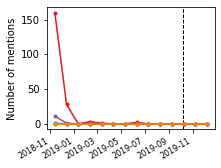

In [295]:
doi = "10.1001/jama.2018.17933"
process_df_fig1(retract_df, 'retract', doi, slide, length, 'fig_1_ret.pdf', legend = False)

In [296]:
doi_control_aids[doi]

['46217397', '16404672', '15547291', '37856120', '15761320']

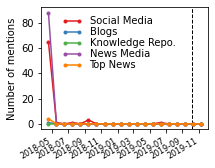

In [297]:
process_df_fig1(control_df, 'control', "37856120", sliding = 30, length = 600, fname = 'fig_1_control.pdf', legend=True)


In [535]:
control_df.loc[control_df.altmetric_id=='37856120']

,altmetric_id,matched_retract_doi,doi,title,abstract,altmetric_pub_date,journal,authors,scopus_subjects,altmetric_score,usable_days,news_media,social_media,blog,knowledge_repo,top_news,tweet_ids,tw_date_sort,fcn_date_sort,uncertainty
15094,37856120,10.1001/jama.2018.17933,10.1001/jama.2018.3185,"Vitamin D, Calcium, or Combined Supplementatio...","Because of the aging population, osteoporotic ...",2018-04-17,JAMA: Journal of the American Medical Association,David C. Grossman;Susan J. Curry;Douglas K. Ow...,Medicine;Health Sciences,688.536,539,"[2018-04-17T04:00:00, 2018-04-17T15:02:00, 201...","[2018-04-17T15:21:21, 2018-04-17T19:35:03, 201...",[2018-04-17T15:00:00],[],"[2018-04-17T15:51:41, 2018-05-08T15:01:08, 201...","[987815594279030784, 988370194132361216, 98848...","[2018-04-17T19:35:03, 2018-04-17T23:58:42, 201...","[3311, 78, 326, 108, 3281, 9590, 4330, 409, 66...",[]


Right - after publication

In [298]:
slide = 30
length = 180

In [299]:
keys_2, series_retract_early = process_df(retract_df, key_col='doi', sliding=slide, length=length)
# exclude control papers for excluded retracted ones.
control_tem = control_df.loc[control_df['matched_retract_doi'].isin(keys_2)]
control_tem.index = range(len(control_tem))
keys_1, series_control_early = process_df(control_tem, key_col='altid', sliding=slide, length=length)

ixx = []
for i, doi in enumerate(keys_2):
    keep = False
    for altid in doi_control_aids[doi]:
        if altid in keys_1:
            keep = True
            break
    if keep:
        ixx.append(i)
        
keys_2 = [keys_2[i] for i in ixx]
series_retract_early = series_retract_early[ixx]

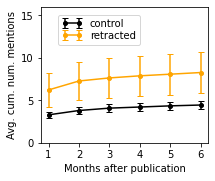

In [306]:
fig, ax = plt.subplots(figsize = (3, 2.5), nrows=1, ncols=1)

# exclude top news counts.
series_data_control = np.array([np.sum(ts[:4, :], axis = 0) for ts in series_control_early])
series_data_control = np.cumsum(series_data_control, axis = 1)
series_data_retract = np.array([np.sum(ts[:4, :], axis = 0) for ts in series_retract_early])
series_data_retract = np.cumsum(series_data_retract, axis = 1)

col1 = 'k'
col2 = '#ffa500'
ys_1 = np.mean(series_data_control, axis=0)
std_1 = np.std(series_data_control, axis=0)
xs = np.arange(len(ys_1)) + 1
ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(series_data_control))), color=col1, fmt='-o', markersize=4, capsize=3, label='control')
ys_2 = np.mean(series_data_retract, axis=0)
std_2 = np.std(series_data_retract, axis=0)
ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(series_data_retract))), color=col2, fmt='-o', markersize=4, capsize=3, label='retracted')

# ax.plot(xs, series_data_control, color=col1, linestyle='-', marker='o', markersize=3, linewidth=1.5, label='control')
# ax.plot(xs, series_data_retract, color=col2, linestyle='-', marker='o', markersize=3, linewidth=1.5, label='retracted')

ax.set_xlabel('Months after publication')
ax.set_ylabel('Avg. cum. num. mentions')
ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_ylim([0, 16])
legend = ax.legend(loc=[0.1, 0.72], numpoints=2, labelspacing = 0.2, shadow=False, frameon = True)
plt.show()
fig.savefig('fig_1_after_pub.pdf', bbox_inches='tight', pad_inches=0.01)

Right - after retraction

In [301]:
keys_2_, series_retract_after = process_df(retract_df, key_col='doi', sliding=slide, length=length, time_type='after_retract')
control_tem = control_df.loc[control_df['matched_retract_doi'].isin(keys_2_)]
control_tem.index = range(len(control_tem))
keys_1_, series_control_after = process_df(control_tem, key_col='altid', sliding=slide, length=length, time_type='after_retract')

ixx = []
for i, doi in enumerate(keys_2_):
    keep = False
    for altid in doi_control_aids[doi]:
        if altid in keys_1_:
            keep = True
            break
    if keep:
        ixx.append(i)
        
keys_2_ = [keys_2_[i] for i in ixx]
series_retract_after = series_retract_after[ixx]

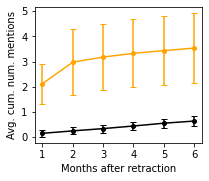

In [302]:
fig, ax = plt.subplots(figsize = (3, 2.5), nrows=1, ncols=1)

# series_data_control = np.cumsum(np.sum(series_control_after[0], axis=0))
# series_data_retract = np.cumsum(np.sum(series_retract_after[0], axis=0))
# xs = np.arange(len(series_data_control)) + 1

col1 = 'k'
col2 = '#ffa500'
series_data_control = np.array([np.sum(ts[:4, :], axis = 0) for ts in series_control_after])
series_data_control = np.cumsum(series_data_control, axis = 1)
series_data_retract = np.array([np.sum(ts[:4, :], axis = 0) for ts in series_retract_after])
series_data_retract = np.cumsum(series_data_retract, axis = 1)

# ax.plot(xs, series_data_control, color=col1, linestyle='-', marker='o', markersize=3, linewidth=1.5, label='control')
# ax.plot(xs, series_data_retract, color=col2, linestyle='-', marker='o', markersize=3, linewidth=1.5, label='retracted')

ys_1 = np.mean(series_data_control, axis=0)
std_1 = np.std(series_data_control, axis=0)
xs = np.arange(len(ys_1)) + 1
ax.errorbar(xs, ys_1, yerr=CIs['95']*(std_1/np.sqrt(len(series_data_control))), color=col1, fmt='-o', markersize=4, capsize=3, label='control')
ys_2 = np.mean(series_data_retract, axis=0)
std_2 = np.std(series_data_retract, axis=0)
ax.errorbar(xs, ys_2, yerr=CIs['95']*(std_2/np.sqrt(len(series_data_retract))), color=col2, fmt='-o', markersize=4, capsize=3, label='retracted')

ax.set_xlabel('Months after retraction')
ax.set_ylabel('Avg. cum. num. mentions')
ax.set_xticks([1, 2, 3, 4, 5, 6])
# ax.set_ylim([-50, 400])
# legend = ax.legend(loc=[0.15, 0.7], numpoints=2, labelspacing = 0.2, shadow=False, frameon = True)
plt.show()
fig.savefig('fig_1_after_ret.pdf', bbox_inches='tight', pad_inches=0.01)